In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "../../data/zz500.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
from xgboost import XGBRegressor

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,close,high,open,low,volume,adj_close,month
2665,2007-01-04,1723.69,1748.091,1738.929,1719.498,3.212987e+09,1723.69,1
2666,2007-01-05,1770.47,1770.483,1719.283,1712.737,2.954547e+09,1770.47,1
1723,2007-01-08,1851.96,1851.964,1773.023,1773.023,3.971932e+09,1851.96,1
1724,2007-01-09,1891.87,1893.723,1855.347,1853.901,4.284591e+09,1891.87,1
2667,2007-01-10,1940.83,1940.832,1896.711,1884.619,4.540634e+09,1940.83,1


Text(0, 0.5, 'USD')

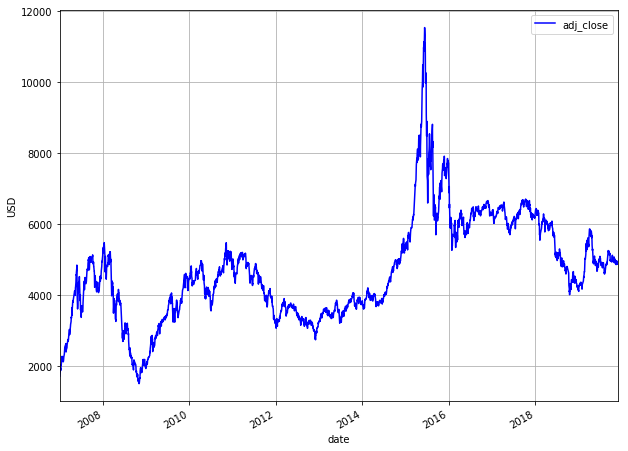

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [5]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,volume,adj_close,month,range_hl,range_oc
2665,2007-01-04,3.212987e+09,1723.69,1,28.593,15.239
2666,2007-01-05,2.954547e+09,1770.47,1,57.746,-51.187
1723,2007-01-08,3.971932e+09,1851.96,1,78.941,-78.937
1724,2007-01-09,4.284591e+09,1891.87,1,39.822,-36.523
2667,2007-01-10,4.540634e+09,1940.83,1,56.213,-44.119


Now we use lags up to N number of days to use as features.

In [6]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [7]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09,1723.69,28.593,15.239,3.212987e+09
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09,1770.47,57.746,-51.187,2.954547e+09
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09,1851.96,78.941,-78.937,3.971932e+09
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09,1891.87,39.822,-36.523,4.284591e+09
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,4.408009e+09,1952.23,69.665,-5.729,5.388346e+09,1940.83,56.213,-44.119,4.540634e+09


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 3 to 3132
Data columns (total 19 columns):
date               3130 non-null datetime64[ns]
volume             3130 non-null float64
adj_close          3130 non-null float64
month              3130 non-null int64
range_hl           3130 non-null float64
range_oc           3130 non-null float64
order_day          3130 non-null int64
adj_close_lag_1    3130 non-null float64
range_hl_lag_1     3130 non-null float64
range_oc_lag_1     3130 non-null float64
volume_lag_1       3130 non-null float64
adj_close_lag_2    3130 non-null float64
range_hl_lag_2     3130 non-null float64
range_oc_lag_2     3130 non-null float64
volume_lag_2       3130 non-null float64
adj_close_lag_3    3130 non-null float64
range_hl_lag_3     3130 non-null float64
range_oc_lag_3     3130 non-null float64
volume_lag_3       3130 non-null float64
dtypes: datetime64[ns](1), float64(16), int64(2)
memory usage: 489.1 KB


In [9]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [10]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [11]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,volume,adj_close,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2007-01-09,4.284591e+09,1891.870,1,39.822,-36.523,3,1851.96,78.941,-78.937,...,15.239,3.212987e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,4.540634e+09,1940.830,1,56.213,-44.119,4,1891.87,39.822,-36.523,...,-51.187,2.954547e+09,1891.870000,NaN,39.822000,NaN,-36.523000,NaN,4.284591e+09,NaN
5,2007-01-11,5.388346e+09,1952.230,1,69.665,-5.729,5,1940.83,56.213,-44.119,...,-78.937,3.971932e+09,1916.350000,34.619948,48.017500,11.590187,-40.321000,5.371183,4.412612e+09,1.810496e+08
6,2007-01-12,4.408009e+09,1881.750,1,93.275,59.595,6,1952.23,69.665,-5.729,...,-36.523,4.284591e+09,1928.310000,32.068601,55.233333,14.945600,-28.790333,20.329624,4.737857e+09,5.777040e+08
7,2007-01-15,3.881263e+09,1986.539,1,105.072,-105.072,7,1881.75,93.275,59.595,...,-44.119,4.540634e+09,1924.936667,37.832607,73.051000,18.761575,3.249000,52.436646,4.778997e+09,5.318626e+08


# Split into train, dev and test set

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1878
num_cv = 626
num_test = 626
train.shape = (1878, 27)
cv.shape = (626, 27)
train_cv.shape = (2504, 27)
test.shape = (626, 27)


# Scale the train, dev and test set

In [13]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 3.81976240e+03  3.81815139e+03  8.99206550e+01 -5.79761235e+00
  4.28182906e+09  3.81652228e+03  8.99266486e+01 -5.81075772e+00
  4.27951687e+09  3.81487635e+03  8.99075149e+01 -5.80916613e+00
  4.27631082e+09]
scaler.var_ = [6.51257445e+05 6.52721072e+05 3.19519759e+03 5.54040873e+03
 3.27992428e+18 6.54406002e+05 3.19474441e+03 5.54127736e+03
 3.27601655e+18 6.56204953e+05 3.19640359e+03 5.54133960e+03
 3.26354151e+18]
train_scaled.shape = (1878, 13)
train_scaled.shape = (1878, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-2.388947,-2.433672,-0.194241,-0.982608,-0.171114,-2.529258,-0.569347,-0.609570,-0.732037,-2.581505,-1.084507,0.282753,-0.588601,2007-01-09,1
1,-2.328278,-2.384273,-0.886293,-0.412787,0.001525,-2.428523,-0.194360,-0.982355,-0.169939,-2.523757,-0.568860,-0.609588,-0.731660,2007-01-10,1
2,-2.314152,-2.323672,-0.596320,-0.514838,0.142903,-2.379187,-0.886462,-0.412578,0.002803,-2.423160,-0.193971,-0.982371,-0.168488,2007-01-11,1
3,-2.401487,-2.309561,-0.358342,0.000922,0.610979,-2.318665,-0.596469,-0.514621,0.144265,-2.373892,-0.885893,-0.412598,0.004583,2007-01-12,1
4,-2.271638,-2.396799,0.059342,0.878532,0.069672,-2.304572,-0.358473,0.001098,0.612621,-2.313452,-0.595975,-0.514639,0.146315,2007-01-15,1


In [14]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 4.51835110e+03  4.51661774e+03  1.06909889e+02 -6.53767508e+00
  5.76561587e+09  4.51485818e+03  1.06917805e+02 -6.55152552e+00
  5.76401042e+09  4.51308631e+03  1.06900577e+02 -6.53706226e+00
  5.76271139e+09]
scaler_train_cv.var_ = [2.31018034e+06 2.31189759e+06 8.79333890e+03 9.41134546e+03
 1.34266533e+19 2.31380602e+06 8.79240364e+03 9.41210174e+03
 1.34292228e+19 2.31583268e+06 8.79435887e+03 9.41220805e+03
 1.34316234e+19]
train_cv_scaled.shape = (2504, 13)
train_cv_scaled.shape = (2504, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.728030,-1.752496,-0.298262,-0.746292,-0.489510,-1.804189,-0.524400,-0.460084,-0.766651,-1.832975,-0.835029,0.224457,-0.695711,2007-01-09,1
1,-1.695818,-1.726248,-0.715430,-0.309089,-0.404183,-1.750617,-0.298363,-0.746119,-0.489026,-1.802235,-0.524158,-0.460230,-0.766228,2007-01-10,1
2,-1.688318,-1.694048,-0.540635,-0.387388,-0.334307,-1.724380,-0.715553,-0.308933,-0.403707,-1.748686,-0.298146,-0.746264,-0.488627,2007-01-11,1
3,-1.734688,-1.686551,-0.397182,0.008336,-0.102960,-1.692193,-0.540748,-0.387230,-0.333837,-1.722461,-0.715289,-0.309081,-0.403316,2007-01-12,1
4,-1.665745,-1.732904,-0.145403,0.681695,-0.370502,-1.684698,-0.397288,0.008478,-0.102512,-1.690288,-0.540505,-0.387377,-0.333453,2007-01-15,1


In [15]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1881,2014-09-30,1.123078,-0.329112,-0.793966,-0.957431,-0.080296,1.037727,-0.642938,-0.509177,1.152115,-0.118848,-0.935265,1.054113
1882,2014-10-08,0.964204,0.068110,-1.032314,0.340770,-1.125847,0.785077,-0.560455,-0.594082,1.154537,0.661492,0.488901,-1.150393
1883,2014-10-09,1.091150,-0.218399,-0.872751,1.126999,-0.345772,-0.781227,-1.154699,0.579148,0.575551,1.150992,-0.495414,-0.655578
1884,2014-10-10,0.682966,0.464847,-1.147813,0.423347,0.718694,-1.142041,0.953605,-1.040698,0.087093,1.069010,-0.156466,-0.912544
1885,2014-10-13,-1.017703,0.981303,0.036400,-1.125634,0.339857,0.785777,0.753045,0.381562,-1.134607,-0.114833,1.052459,-0.937626


In [16]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2507,2017-04-28,0.999680,0.000641,-1.000320,1.105941,-0.840497,-0.265444,-1.122471,0.795851,0.326620,1.132518,-0.371189,-0.761329
2508,2017-05-02,1.032500,-0.068525,-0.963975,-0.501453,1.151509,-0.650055,-0.700262,-0.444994,1.145257,-0.694367,1.146177,-0.451810
2509,2017-05-03,0.736641,0.401757,-1.138398,-0.701438,-0.443629,1.145067,1.148891,-0.674628,-0.474263,-0.426458,-0.716072,1.142530
2510,2017-05-04,-1.127004,0.781209,0.345795,0.731839,-1.139424,0.407585,0.941490,0.108217,-1.049707,0.913831,0.154382,-1.068213
2511,2017-05-05,-1.020540,0.042432,0.978109,1.071546,-0.163159,-0.908387,0.340075,0.785609,-1.125685,1.101683,-0.251307,-0.850376


# Split into X and y

In [17]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (1878, 12)
y_train.shape = (1878,)
X_cv.shape = (626, 12)
y_cv.shape = (626,)
X_train_cv.shape = (2504, 12)
y_train_cv.shape = (2504,)
X_sample.shape = (626, 12)
y_sample.shape = (626,)


In [18]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1878, 12)
y_train_scaled.shape = (1878,)
X_cv_scaled.shape = (626, 12)
X_train_cv_scaled.shape = (2504, 12)
y_train_cv_scaled.shape = (2504,)
X_sample_scaled.shape = (626, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

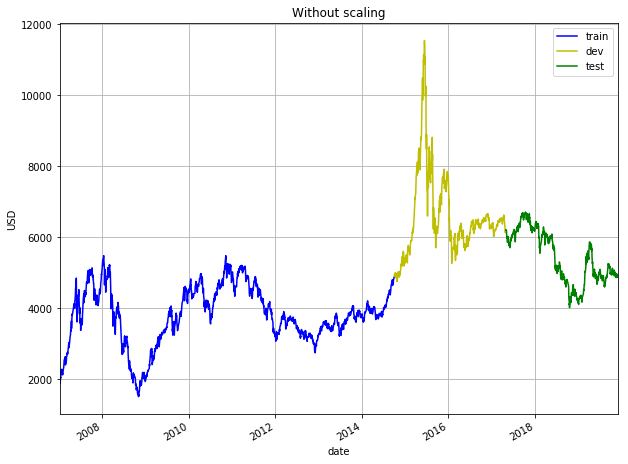

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

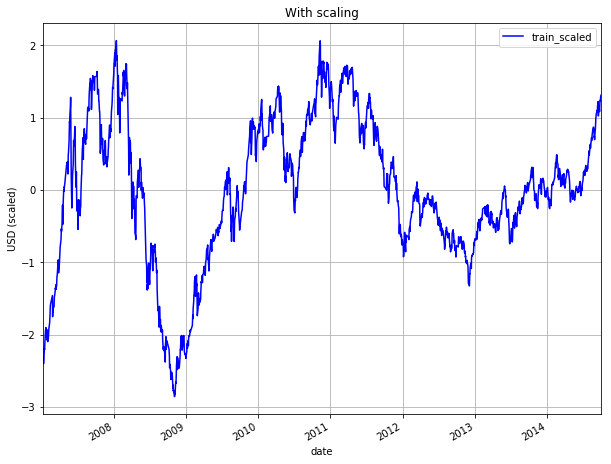

In [20]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [21]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from src.stacking.models.m1_xgb import *
from src.conf.configuration import regress_conf

# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_scaled.values, y_train_scaled.values)


2019-11-29 16:31:45,917 - ../../../src/stacking/models/m1_xgb.py[line:97] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.01014	train-logloss:0.204921
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[1]	train-rmse:0.912813	train-logloss:-5.37107
[2]	train-rmse:0.825306	train-logloss:-7.14703
[3]	train-rmse:0.74588	train-logloss:-9.05436
[4]	train-rmse:0.674852	train-logloss:-11.06
[5]	train-rmse:0.610594	train-logloss:-12.1038
[6]	train-rmse:0.552994	train-logloss:-14.0991
[7]	train-rmse:0.501163	train-logloss:-14.8944
[8]	train-rmse:0.454525	train-logloss:-15.4543
[9]	train-rmse:0.41262	train-logloss:-15.7567
[10]	train-rmse:0.374831	train-logloss:-15.8613
[11]	train-rmse:0.340991	train-logloss:-16.135
[12]	train-rmse:0.310796	train-logloss:-16.2275
[13]	train-rmse:0.283712	train-logloss:-16.3421
[14]	train-rmse:0.259559	train-logloss:-16.3487
[15]	train-rmse:0.237996	train-logloss:-16.3528
[16]	train-rmse:0.218751	train-logloss:-16.3626
[17]	train-rmse:0.20178	train-logloss:-16.4045


[168]	train-rmse:0.071262	train-logloss:-16.6242
[169]	train-rmse:0.071139	train-logloss:-16.6241
[170]	train-rmse:0.071024	train-logloss:-16.6242
[171]	train-rmse:0.070984	train-logloss:-16.6242
[172]	train-rmse:0.070889	train-logloss:-16.6242
[173]	train-rmse:0.070806	train-logloss:-16.6242
[174]	train-rmse:0.070666	train-logloss:-16.6242
[175]	train-rmse:0.070578	train-logloss:-16.6242
[176]	train-rmse:0.070405	train-logloss:-16.6243
[177]	train-rmse:0.070313	train-logloss:-16.6243
[178]	train-rmse:0.070139	train-logloss:-16.6243
[179]	train-rmse:0.070053	train-logloss:-16.6243
[180]	train-rmse:0.069918	train-logloss:-16.6244
[181]	train-rmse:0.069851	train-logloss:-16.6244
[182]	train-rmse:0.069813	train-logloss:-16.6245
[183]	train-rmse:0.069772	train-logloss:-16.6245
[184]	train-rmse:0.069605	train-logloss:-16.6245
[185]	train-rmse:0.069505	train-logloss:-16.6245
[186]	train-rmse:0.069367	train-logloss:-16.6246
[187]	train-rmse:0.069271	train-logloss:-16.6246
[188]	train-rmse:0.0

[337]	train-rmse:0.058238	train-logloss:-16.6348
[338]	train-rmse:0.058199	train-logloss:-16.6348
[339]	train-rmse:0.05811	train-logloss:-16.6349
[340]	train-rmse:0.05802	train-logloss:-16.6349
[341]	train-rmse:0.05801	train-logloss:-16.6349
[342]	train-rmse:0.057955	train-logloss:-16.6349
[343]	train-rmse:0.057871	train-logloss:-16.6349
[344]	train-rmse:0.057782	train-logloss:-16.6349
[345]	train-rmse:0.057688	train-logloss:-16.635
[346]	train-rmse:0.05765	train-logloss:-16.635
[347]	train-rmse:0.057593	train-logloss:-16.6359
[348]	train-rmse:0.057568	train-logloss:-16.6359
[349]	train-rmse:0.057506	train-logloss:-16.6355
[350]	train-rmse:0.057424	train-logloss:-16.6355
[351]	train-rmse:0.057415	train-logloss:-16.6355
[352]	train-rmse:0.057373	train-logloss:-16.6355
[353]	train-rmse:0.057291	train-logloss:-16.6355
[354]	train-rmse:0.057274	train-logloss:-16.6355
[355]	train-rmse:0.057184	train-logloss:-16.6355
[356]	train-rmse:0.057155	train-logloss:-16.6355
[357]	train-rmse:0.057075	

[505]	train-rmse:0.048902	train-logloss:-16.6491
[506]	train-rmse:0.048885	train-logloss:-16.6491
[507]	train-rmse:0.048837	train-logloss:-16.6491
[508]	train-rmse:0.048756	train-logloss:-16.6497
[509]	train-rmse:0.048712	train-logloss:-16.6497
[510]	train-rmse:0.048672	train-logloss:-16.6497
[511]	train-rmse:0.048645	train-logloss:-16.6497
[512]	train-rmse:0.048609	train-logloss:-16.6497
[513]	train-rmse:0.048581	train-logloss:-16.6497
[514]	train-rmse:0.04854	train-logloss:-16.6514
[515]	train-rmse:0.048463	train-logloss:-16.6514
[516]	train-rmse:0.048387	train-logloss:-16.6515
[517]	train-rmse:0.048328	train-logloss:-16.6515
[518]	train-rmse:0.0483	train-logloss:-16.6515
[519]	train-rmse:0.048278	train-logloss:-16.6515
[520]	train-rmse:0.04822	train-logloss:-16.6515
[521]	train-rmse:0.048149	train-logloss:-16.6515
[522]	train-rmse:0.048095	train-logloss:-16.6515
[523]	train-rmse:0.048065	train-logloss:-16.6515
[524]	train-rmse:0.047987	train-logloss:-16.6516
[525]	train-rmse:0.04792

[673]	train-rmse:0.041416	train-logloss:-16.6626
[674]	train-rmse:0.041366	train-logloss:-16.6626
[675]	train-rmse:0.041298	train-logloss:-16.6626
[676]	train-rmse:0.041248	train-logloss:-16.6628
[677]	train-rmse:0.041228	train-logloss:-16.6628
[678]	train-rmse:0.041187	train-logloss:-16.663
[679]	train-rmse:0.041142	train-logloss:-16.6629
[680]	train-rmse:0.041078	train-logloss:-16.6629
[681]	train-rmse:0.041046	train-logloss:-16.6629
[682]	train-rmse:0.041026	train-logloss:-16.6629
[683]	train-rmse:0.041011	train-logloss:-16.6627
[684]	train-rmse:0.040968	train-logloss:-16.6629
[685]	train-rmse:0.040889	train-logloss:-16.6629
[686]	train-rmse:0.040838	train-logloss:-16.6629
[687]	train-rmse:0.040812	train-logloss:-16.6629
[688]	train-rmse:0.040801	train-logloss:-16.6629
[689]	train-rmse:0.040769	train-logloss:-16.6629
[690]	train-rmse:0.040759	train-logloss:-16.6629
[691]	train-rmse:0.040706	train-logloss:-16.6629
[692]	train-rmse:0.040678	train-logloss:-16.663
[693]	train-rmse:0.040

[842]	train-rmse:0.03539	train-logloss:-16.6665
[843]	train-rmse:0.035382	train-logloss:-16.6665
[844]	train-rmse:0.035349	train-logloss:-16.6665
[845]	train-rmse:0.035328	train-logloss:-16.6665
[846]	train-rmse:0.035288	train-logloss:-16.6665
[847]	train-rmse:0.035229	train-logloss:-16.6667
[848]	train-rmse:0.035189	train-logloss:-16.6667
[849]	train-rmse:0.035123	train-logloss:-16.6668
[850]	train-rmse:0.035087	train-logloss:-16.6668
[851]	train-rmse:0.035051	train-logloss:-16.6668
[852]	train-rmse:0.035018	train-logloss:-16.6668
[853]	train-rmse:0.034977	train-logloss:-16.6668
[854]	train-rmse:0.034947	train-logloss:-16.6666
[855]	train-rmse:0.03491	train-logloss:-16.6669
[856]	train-rmse:0.034873	train-logloss:-16.6669
[857]	train-rmse:0.034824	train-logloss:-16.6669
[858]	train-rmse:0.034789	train-logloss:-16.6669
[859]	train-rmse:0.034738	train-logloss:-16.6669
[860]	train-rmse:0.034709	train-logloss:-16.6669
[861]	train-rmse:0.034658	train-logloss:-16.667
[862]	train-rmse:0.0346

[1010]	train-rmse:0.030398	train-logloss:-16.6743
[1011]	train-rmse:0.030374	train-logloss:-16.6743
[1012]	train-rmse:0.030345	train-logloss:-16.6743
[1013]	train-rmse:0.030312	train-logloss:-16.6743
[1014]	train-rmse:0.03028	train-logloss:-16.6744
[1015]	train-rmse:0.030243	train-logloss:-16.6744
[1016]	train-rmse:0.030204	train-logloss:-16.6744
[1017]	train-rmse:0.03018	train-logloss:-16.6744
[1018]	train-rmse:0.030147	train-logloss:-16.6744
[1019]	train-rmse:0.030114	train-logloss:-16.6744
[1020]	train-rmse:0.030076	train-logloss:-16.6744
[1021]	train-rmse:0.030053	train-logloss:-16.6744
[1022]	train-rmse:0.030027	train-logloss:-16.6744
[1023]	train-rmse:0.030007	train-logloss:-16.6744
[1024]	train-rmse:0.029969	train-logloss:-16.6744
[1025]	train-rmse:0.029961	train-logloss:-16.6744
[1026]	train-rmse:0.029952	train-logloss:-16.6744
[1027]	train-rmse:0.02991	train-logloss:-16.6745
[1028]	train-rmse:0.029872	train-logloss:-16.6745
[1029]	train-rmse:0.029869	train-logloss:-16.6745
[10

[1175]	train-rmse:0.025966	train-logloss:-16.6786
[1176]	train-rmse:0.025938	train-logloss:-16.6786
[1177]	train-rmse:0.025912	train-logloss:-16.6786
[1178]	train-rmse:0.025875	train-logloss:-16.6786
[1179]	train-rmse:0.025843	train-logloss:-16.6786
[1180]	train-rmse:0.025822	train-logloss:-16.6786
[1181]	train-rmse:0.025803	train-logloss:-16.6789
[1182]	train-rmse:0.025785	train-logloss:-16.6789
[1183]	train-rmse:0.025743	train-logloss:-16.6786
[1184]	train-rmse:0.025727	train-logloss:-16.6786
[1185]	train-rmse:0.025722	train-logloss:-16.6786
[1186]	train-rmse:0.025695	train-logloss:-16.6786
[1187]	train-rmse:0.025657	train-logloss:-16.6786
[1188]	train-rmse:0.025641	train-logloss:-16.6786
[1189]	train-rmse:0.025612	train-logloss:-16.6786
[1190]	train-rmse:0.02559	train-logloss:-16.6786
[1191]	train-rmse:0.025578	train-logloss:-16.6786
[1192]	train-rmse:0.02555	train-logloss:-16.6786
[1193]	train-rmse:0.025527	train-logloss:-16.6786
[1194]	train-rmse:0.025496	train-logloss:-16.6786
[1

[1340]	train-rmse:0.022407	train-logloss:-16.6811
[1341]	train-rmse:0.022383	train-logloss:-16.6811
[1342]	train-rmse:0.02237	train-logloss:-16.6811
[1343]	train-rmse:0.022343	train-logloss:-16.6811
[1344]	train-rmse:0.022329	train-logloss:-16.6811
[1345]	train-rmse:0.022318	train-logloss:-16.6811
[1346]	train-rmse:0.022299	train-logloss:-16.6811
[1347]	train-rmse:0.022276	train-logloss:-16.6811
[1348]	train-rmse:0.022249	train-logloss:-16.6811
[1349]	train-rmse:0.022232	train-logloss:-16.6811
[1350]	train-rmse:0.022204	train-logloss:-16.6813
[1351]	train-rmse:0.022183	train-logloss:-16.6813
[1352]	train-rmse:0.022163	train-logloss:-16.6813
[1353]	train-rmse:0.022132	train-logloss:-16.6813
[1354]	train-rmse:0.022108	train-logloss:-16.6814
[1355]	train-rmse:0.022084	train-logloss:-16.6813
[1356]	train-rmse:0.022061	train-logloss:-16.6814
[1357]	train-rmse:0.022053	train-logloss:-16.6814
[1358]	train-rmse:0.022042	train-logloss:-16.6815
[1359]	train-rmse:0.022021	train-logloss:-16.6815
[

[1505]	train-rmse:0.019352	train-logloss:-16.6845
[1506]	train-rmse:0.019322	train-logloss:-16.6845
[1507]	train-rmse:0.019311	train-logloss:-16.6845
[1508]	train-rmse:0.019303	train-logloss:-16.6845
[1509]	train-rmse:0.019299	train-logloss:-16.6845
[1510]	train-rmse:0.019278	train-logloss:-16.6845
[1511]	train-rmse:0.019258	train-logloss:-16.6845
[1512]	train-rmse:0.019251	train-logloss:-16.6845
[1513]	train-rmse:0.019239	train-logloss:-16.6852
[1514]	train-rmse:0.01922	train-logloss:-16.6852
[1515]	train-rmse:0.019198	train-logloss:-16.6852
[1516]	train-rmse:0.019172	train-logloss:-16.6852
[1517]	train-rmse:0.019157	train-logloss:-16.6852
[1518]	train-rmse:0.019139	train-logloss:-16.6852
[1519]	train-rmse:0.019123	train-logloss:-16.6852
[1520]	train-rmse:0.019121	train-logloss:-16.6852
[1521]	train-rmse:0.019113	train-logloss:-16.6852
[1522]	train-rmse:0.019106	train-logloss:-16.6852
[1523]	train-rmse:0.019084	train-logloss:-16.6852
[1524]	train-rmse:0.01906	train-logloss:-16.6852
[1

[1670]	train-rmse:0.016848	train-logloss:-16.6867
[1671]	train-rmse:0.016838	train-logloss:-16.6867
[1672]	train-rmse:0.016831	train-logloss:-16.6867
[1673]	train-rmse:0.016817	train-logloss:-16.6867
[1674]	train-rmse:0.016812	train-logloss:-16.6867
[1675]	train-rmse:0.016792	train-logloss:-16.6867
[1676]	train-rmse:0.01677	train-logloss:-16.6867
[1677]	train-rmse:0.016749	train-logloss:-16.6867
[1678]	train-rmse:0.016724	train-logloss:-16.6867
[1679]	train-rmse:0.016707	train-logloss:-16.6867
[1680]	train-rmse:0.016689	train-logloss:-16.6867
[1681]	train-rmse:0.016682	train-logloss:-16.6867
[1682]	train-rmse:0.016673	train-logloss:-16.6867
[1683]	train-rmse:0.016656	train-logloss:-16.6875
[1684]	train-rmse:0.016647	train-logloss:-16.6875
[1685]	train-rmse:0.016629	train-logloss:-16.6875
[1686]	train-rmse:0.016617	train-logloss:-16.6875
[1687]	train-rmse:0.016599	train-logloss:-16.6875
[1688]	train-rmse:0.016584	train-logloss:-16.6875
[1689]	train-rmse:0.016567	train-logloss:-16.6875
[

[1835]	train-rmse:0.014794	train-logloss:-16.6878
[1836]	train-rmse:0.014779	train-logloss:-16.6878
[1837]	train-rmse:0.014765	train-logloss:-16.6878
[1838]	train-rmse:0.014753	train-logloss:-16.6878
[1839]	train-rmse:0.014748	train-logloss:-16.6878
[1840]	train-rmse:0.014732	train-logloss:-16.6878
[1841]	train-rmse:0.01473	train-logloss:-16.6878
[1842]	train-rmse:0.014722	train-logloss:-16.6878
[1843]	train-rmse:0.014709	train-logloss:-16.6878
[1844]	train-rmse:0.014688	train-logloss:-16.6878
[1845]	train-rmse:0.014668	train-logloss:-16.6878
[1846]	train-rmse:0.014662	train-logloss:-16.6878
[1847]	train-rmse:0.014644	train-logloss:-16.6878
[1848]	train-rmse:0.014641	train-logloss:-16.6878
[1849]	train-rmse:0.014628	train-logloss:-16.6878
[1850]	train-rmse:0.014616	train-logloss:-16.6878
[1851]	train-rmse:0.014612	train-logloss:-16.6878
[1852]	train-rmse:0.014593	train-logloss:-16.6878
[1853]	train-rmse:0.014578	train-logloss:-16.6878
[1854]	train-rmse:0.014566	train-logloss:-16.6878
[

[2000]	train-rmse:0.013056	train-logloss:-16.6881
[2001]	train-rmse:0.013047	train-logloss:-16.6881
[2002]	train-rmse:0.013034	train-logloss:-16.6881
[2003]	train-rmse:0.013025	train-logloss:-16.6881
[2004]	train-rmse:0.013015	train-logloss:-16.6881
[2005]	train-rmse:0.013008	train-logloss:-16.6881
[2006]	train-rmse:0.012997	train-logloss:-16.6881
[2007]	train-rmse:0.012988	train-logloss:-16.6881
[2008]	train-rmse:0.012983	train-logloss:-16.6881
[2009]	train-rmse:0.012979	train-logloss:-16.6881
[2010]	train-rmse:0.012973	train-logloss:-16.6881
[2011]	train-rmse:0.012967	train-logloss:-16.6881
[2012]	train-rmse:0.012964	train-logloss:-16.6881
[2013]	train-rmse:0.012943	train-logloss:-16.6881
[2014]	train-rmse:0.012936	train-logloss:-16.6881
[2015]	train-rmse:0.012928	train-logloss:-16.6881
[2016]	train-rmse:0.012913	train-logloss:-16.6881
[2017]	train-rmse:0.012906	train-logloss:-16.6881
[2018]	train-rmse:0.012901	train-logloss:-16.6881
[2019]	train-rmse:0.012887	train-logloss:-16.6881


[2165]	train-rmse:0.011551	train-logloss:-16.6889
[2166]	train-rmse:0.011539	train-logloss:-16.6889
[2167]	train-rmse:0.01153	train-logloss:-16.6889
[2168]	train-rmse:0.011518	train-logloss:-16.6889
[2169]	train-rmse:0.011508	train-logloss:-16.6889
[2170]	train-rmse:0.011499	train-logloss:-16.6889
[2171]	train-rmse:0.01149	train-logloss:-16.6889
[2172]	train-rmse:0.011476	train-logloss:-16.6889
[2173]	train-rmse:0.011469	train-logloss:-16.6889
[2174]	train-rmse:0.011464	train-logloss:-16.6889
[2175]	train-rmse:0.011461	train-logloss:-16.6889
[2176]	train-rmse:0.01146	train-logloss:-16.6889
[2177]	train-rmse:0.01145	train-logloss:-16.6889
[2178]	train-rmse:0.011439	train-logloss:-16.6889
[2179]	train-rmse:0.011436	train-logloss:-16.6889
[2180]	train-rmse:0.011433	train-logloss:-16.6889
[2181]	train-rmse:0.011426	train-logloss:-16.6889
[2182]	train-rmse:0.011425	train-logloss:-16.6889
[2183]	train-rmse:0.011417	train-logloss:-16.6889
[2184]	train-rmse:0.011403	train-logloss:-16.6889
[218

[2331]	train-rmse:0.010133	train-logloss:-16.6891
[2332]	train-rmse:0.010125	train-logloss:-16.6891
[2333]	train-rmse:0.010116	train-logloss:-16.6891
[2334]	train-rmse:0.010111	train-logloss:-16.6891
[2335]	train-rmse:0.010101	train-logloss:-16.6891
[2336]	train-rmse:0.010095	train-logloss:-16.6891
[2337]	train-rmse:0.010087	train-logloss:-16.6891
[2338]	train-rmse:0.010078	train-logloss:-16.6891
[2339]	train-rmse:0.010067	train-logloss:-16.6891
[2340]	train-rmse:0.010063	train-logloss:-16.6891
[2341]	train-rmse:0.010056	train-logloss:-16.6891
[2342]	train-rmse:0.01005	train-logloss:-16.6891
[2343]	train-rmse:0.010046	train-logloss:-16.6891
[2344]	train-rmse:0.010037	train-logloss:-16.6891
[2345]	train-rmse:0.010028	train-logloss:-16.6891
[2346]	train-rmse:0.010021	train-logloss:-16.6891
[2347]	train-rmse:0.010011	train-logloss:-16.6894
[2348]	train-rmse:0.010004	train-logloss:-16.6894
[2349]	train-rmse:0.009999	train-logloss:-16.6894
[2350]	train-rmse:0.009994	train-logloss:-16.6894
[

[2496]	train-rmse:0.008979	train-logloss:-16.6899
[2497]	train-rmse:0.008969	train-logloss:-16.6899
[2498]	train-rmse:0.008965	train-logloss:-16.6899
[2499]	train-rmse:0.008963	train-logloss:-16.6899
[2500]	train-rmse:0.008958	train-logloss:-16.6899
[2501]	train-rmse:0.008952	train-logloss:-16.6899
[2502]	train-rmse:0.008942	train-logloss:-16.6899
[2503]	train-rmse:0.008938	train-logloss:-16.6899
[2504]	train-rmse:0.008931	train-logloss:-16.6899
[2505]	train-rmse:0.008923	train-logloss:-16.6899
[2506]	train-rmse:0.00892	train-logloss:-16.6899
[2507]	train-rmse:0.008911	train-logloss:-16.6899
[2508]	train-rmse:0.008909	train-logloss:-16.6899
[2509]	train-rmse:0.0089	train-logloss:-16.6899
[2510]	train-rmse:0.008892	train-logloss:-16.6899
[2511]	train-rmse:0.008885	train-logloss:-16.6899
[2512]	train-rmse:0.008873	train-logloss:-16.6899
[2513]	train-rmse:0.008855	train-logloss:-16.6899
[2514]	train-rmse:0.008849	train-logloss:-16.6899
[2515]	train-rmse:0.008841	train-logloss:-16.6899
[25

[2661]	train-rmse:0.007914	train-logloss:-16.69
[2662]	train-rmse:0.007912	train-logloss:-16.69
[2663]	train-rmse:0.007907	train-logloss:-16.69
[2664]	train-rmse:0.007898	train-logloss:-16.69
[2665]	train-rmse:0.007893	train-logloss:-16.69
[2666]	train-rmse:0.007886	train-logloss:-16.69
[2667]	train-rmse:0.007879	train-logloss:-16.69
[2668]	train-rmse:0.007877	train-logloss:-16.69
[2669]	train-rmse:0.00787	train-logloss:-16.69
[2670]	train-rmse:0.007861	train-logloss:-16.69
[2671]	train-rmse:0.007852	train-logloss:-16.69
[2672]	train-rmse:0.007846	train-logloss:-16.69
[2673]	train-rmse:0.007839	train-logloss:-16.69
[2674]	train-rmse:0.007832	train-logloss:-16.69
[2675]	train-rmse:0.007829	train-logloss:-16.69
[2676]	train-rmse:0.007825	train-logloss:-16.69
[2677]	train-rmse:0.007822	train-logloss:-16.69
[2678]	train-rmse:0.007814	train-logloss:-16.69
[2679]	train-rmse:0.00781	train-logloss:-16.69
[2680]	train-rmse:0.00781	train-logloss:-16.69
[2681]	train-rmse:0.007805	train-logloss:-1

[2830]	train-rmse:0.006999	train-logloss:-16.6902
[2831]	train-rmse:0.006995	train-logloss:-16.6902
[2832]	train-rmse:0.006988	train-logloss:-16.6902
[2833]	train-rmse:0.006984	train-logloss:-16.6902
[2834]	train-rmse:0.006979	train-logloss:-16.6902
[2835]	train-rmse:0.006977	train-logloss:-16.6902
[2836]	train-rmse:0.006974	train-logloss:-16.6902
[2837]	train-rmse:0.006966	train-logloss:-16.6902
[2838]	train-rmse:0.006958	train-logloss:-16.6902
[2839]	train-rmse:0.006951	train-logloss:-16.6902
[2840]	train-rmse:0.006948	train-logloss:-16.6902
[2841]	train-rmse:0.006943	train-logloss:-16.6902
[2842]	train-rmse:0.006936	train-logloss:-16.6902
[2843]	train-rmse:0.006928	train-logloss:-16.6902
[2844]	train-rmse:0.00692	train-logloss:-16.6902
[2845]	train-rmse:0.006912	train-logloss:-16.6902
[2846]	train-rmse:0.006906	train-logloss:-16.6902
[2847]	train-rmse:0.006897	train-logloss:-16.6902
[2848]	train-rmse:0.006891	train-logloss:-16.6902
[2849]	train-rmse:0.006885	train-logloss:-16.6902
[

[2995]	train-rmse:0.006167	train-logloss:-16.6907
[2996]	train-rmse:0.006166	train-logloss:-16.6907
[2997]	train-rmse:0.006161	train-logloss:-16.6907


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[3625]	train-rmse:0.00387	train-logloss:-16.6913
[3626]	train-rmse:0.003868	train-logloss:-16.6913
[3627]	train-rmse:0.003868	train-logloss:-16.6913
[3628]	train-rmse:0.003865	train-logloss:-16.6913
[3629]	train-rmse:0.003862	train-logloss:-16.6913
[3630]	train-rmse:0.003858	train-logloss:-16.6913
[3631]	train-rmse:0.003854	train-logloss:-16.6913
[3632]	train-rmse:0.003852	train-logloss:-16.6913
[3633]	train-rmse:0.003851	train-logloss:-16.6913
[3634]	train-rmse:0.003848	train-logloss:-16.6913
[3635]	train-rmse:0.003848	train-logloss:-16.6913
[3636]	train-rmse:0.003846	train-logloss:-16.6913
[3637]	train-rmse:0.003843	train-logloss:-16.6913
[3638]	train-rmse:0.003841	train-logloss:-16.6914
[3639]	train-rmse:0.003838	train-logloss:-16.6914
[3640]	train-rmse:0.003838	train-logloss:-16.6914
[3641]	train-rmse:0.003836	train-logloss:-16.6914
[3642]	train-rmse:0.003833	train-logloss:-16.6914
[3643]	train-rmse:0.00383	train-logloss:-16.6914
[3644]	train-rmse:0.003828	train-logloss:-16.6914
[3

[3790]	train-rmse:0.003454	train-logloss:-16.6914
[3791]	train-rmse:0.003452	train-logloss:-16.6914
[3792]	train-rmse:0.003447	train-logloss:-16.6914
[3793]	train-rmse:0.003445	train-logloss:-16.6914
[3794]	train-rmse:0.003442	train-logloss:-16.6914
[3795]	train-rmse:0.003439	train-logloss:-16.6914
[3796]	train-rmse:0.003437	train-logloss:-16.6914
[3797]	train-rmse:0.003435	train-logloss:-16.6914
[3798]	train-rmse:0.003432	train-logloss:-16.6914
[3799]	train-rmse:0.003431	train-logloss:-16.6914
[3800]	train-rmse:0.003428	train-logloss:-16.6914
[3801]	train-rmse:0.003424	train-logloss:-16.6914
[3802]	train-rmse:0.003422	train-logloss:-16.6914
[3803]	train-rmse:0.003418	train-logloss:-16.6914
[3804]	train-rmse:0.003415	train-logloss:-16.6914
[3805]	train-rmse:0.003412	train-logloss:-16.6914
[3806]	train-rmse:0.003408	train-logloss:-16.6914
[3807]	train-rmse:0.003406	train-logloss:-16.6914
[3808]	train-rmse:0.003404	train-logloss:-16.6914
[3809]	train-rmse:0.003403	train-logloss:-16.6914


[3955]	train-rmse:0.003062	train-logloss:-16.6915
[3956]	train-rmse:0.003059	train-logloss:-16.6915
[3957]	train-rmse:0.003054	train-logloss:-16.6915
[3958]	train-rmse:0.00305	train-logloss:-16.6915
[3959]	train-rmse:0.003047	train-logloss:-16.6915
[3960]	train-rmse:0.003044	train-logloss:-16.6915
[3961]	train-rmse:0.003042	train-logloss:-16.6915
[3962]	train-rmse:0.00304	train-logloss:-16.6915
[3963]	train-rmse:0.003037	train-logloss:-16.6915
[3964]	train-rmse:0.003034	train-logloss:-16.6915
[3965]	train-rmse:0.003034	train-logloss:-16.6915
[3966]	train-rmse:0.003031	train-logloss:-16.6915
[3967]	train-rmse:0.003028	train-logloss:-16.6915
[3968]	train-rmse:0.003025	train-logloss:-16.6915
[3969]	train-rmse:0.003021	train-logloss:-16.6915
[3970]	train-rmse:0.003019	train-logloss:-16.6915
[3971]	train-rmse:0.003017	train-logloss:-16.6915
[3972]	train-rmse:0.003015	train-logloss:-16.6915
[3973]	train-rmse:0.003014	train-logloss:-16.6915
[3974]	train-rmse:0.003011	train-logloss:-16.6915
[3

[4120]	train-rmse:0.002739	train-logloss:-16.6915
[4121]	train-rmse:0.002735	train-logloss:-16.6915
[4122]	train-rmse:0.002733	train-logloss:-16.6915
[4123]	train-rmse:0.002733	train-logloss:-16.6915
[4124]	train-rmse:0.002731	train-logloss:-16.6915
[4125]	train-rmse:0.00273	train-logloss:-16.6915
[4126]	train-rmse:0.002728	train-logloss:-16.6915
[4127]	train-rmse:0.002727	train-logloss:-16.6915
[4128]	train-rmse:0.002724	train-logloss:-16.6915
[4129]	train-rmse:0.002723	train-logloss:-16.6915
[4130]	train-rmse:0.002723	train-logloss:-16.6915
[4131]	train-rmse:0.002722	train-logloss:-16.6915
[4132]	train-rmse:0.002722	train-logloss:-16.6915
[4133]	train-rmse:0.00272	train-logloss:-16.6915
[4134]	train-rmse:0.002719	train-logloss:-16.6915
[4135]	train-rmse:0.002717	train-logloss:-16.6915
[4136]	train-rmse:0.002715	train-logloss:-16.6915
[4137]	train-rmse:0.002713	train-logloss:-16.6915
[4138]	train-rmse:0.002711	train-logloss:-16.6915
[4139]	train-rmse:0.002709	train-logloss:-16.6915
[4

[4285]	train-rmse:0.002461	train-logloss:-16.6915
[4286]	train-rmse:0.00246	train-logloss:-16.6915
[4287]	train-rmse:0.002457	train-logloss:-16.6915
[4288]	train-rmse:0.002456	train-logloss:-16.6915
[4289]	train-rmse:0.002455	train-logloss:-16.6915
[4290]	train-rmse:0.002453	train-logloss:-16.6915
[4291]	train-rmse:0.002452	train-logloss:-16.6915
[4292]	train-rmse:0.002451	train-logloss:-16.6915
[4293]	train-rmse:0.00245	train-logloss:-16.6915
[4294]	train-rmse:0.002448	train-logloss:-16.6915
[4295]	train-rmse:0.002447	train-logloss:-16.6915
[4296]	train-rmse:0.002446	train-logloss:-16.6915
[4297]	train-rmse:0.002443	train-logloss:-16.6915
[4298]	train-rmse:0.002443	train-logloss:-16.6915
[4299]	train-rmse:0.002441	train-logloss:-16.6915
[4300]	train-rmse:0.00244	train-logloss:-16.6915
[4301]	train-rmse:0.002438	train-logloss:-16.6915
[4302]	train-rmse:0.002437	train-logloss:-16.6915
[4303]	train-rmse:0.002436	train-logloss:-16.6915
[4304]	train-rmse:0.002435	train-logloss:-16.6915
[43

[4451]	train-rmse:0.00229	train-logloss:-16.6915
[4452]	train-rmse:0.00229	train-logloss:-16.6915
[4453]	train-rmse:0.00229	train-logloss:-16.6915
[4454]	train-rmse:0.00229	train-logloss:-16.6915
[4455]	train-rmse:0.00229	train-logloss:-16.6915
[4456]	train-rmse:0.00229	train-logloss:-16.6915
[4457]	train-rmse:0.00229	train-logloss:-16.6915
[4458]	train-rmse:0.00229	train-logloss:-16.6915
[4459]	train-rmse:0.00229	train-logloss:-16.6915
[4460]	train-rmse:0.00229	train-logloss:-16.6915
[4461]	train-rmse:0.00229	train-logloss:-16.6915
[4462]	train-rmse:0.00229	train-logloss:-16.6915
[4463]	train-rmse:0.00229	train-logloss:-16.6915
[4464]	train-rmse:0.00229	train-logloss:-16.6915
[4465]	train-rmse:0.00229	train-logloss:-16.6915
[4466]	train-rmse:0.00229	train-logloss:-16.6915
[4467]	train-rmse:0.00229	train-logloss:-16.6915
[4468]	train-rmse:0.00229	train-logloss:-16.6915
[4469]	train-rmse:0.00229	train-logloss:-16.6915
[4470]	train-rmse:0.00229	train-logloss:-16.6915
[4471]	train-rmse:0.

[4619]	train-rmse:0.00229	train-logloss:-16.6915
[4620]	train-rmse:0.00229	train-logloss:-16.6915
[4621]	train-rmse:0.00229	train-logloss:-16.6915
[4622]	train-rmse:0.00229	train-logloss:-16.6915
[4623]	train-rmse:0.00229	train-logloss:-16.6915
[4624]	train-rmse:0.00229	train-logloss:-16.6915
[4625]	train-rmse:0.00229	train-logloss:-16.6915
[4626]	train-rmse:0.00229	train-logloss:-16.6915
[4627]	train-rmse:0.00229	train-logloss:-16.6915
[4628]	train-rmse:0.00229	train-logloss:-16.6915
[4629]	train-rmse:0.00229	train-logloss:-16.6915
[4630]	train-rmse:0.00229	train-logloss:-16.6915
[4631]	train-rmse:0.00229	train-logloss:-16.6915
[4632]	train-rmse:0.00229	train-logloss:-16.6915
[4633]	train-rmse:0.00229	train-logloss:-16.6915
[4634]	train-rmse:0.00229	train-logloss:-16.6915
[4635]	train-rmse:0.00229	train-logloss:-16.6915
[4636]	train-rmse:0.00229	train-logloss:-16.6915
[4637]	train-rmse:0.00229	train-logloss:-16.6915
[4638]	train-rmse:0.00229	train-logloss:-16.6915
[4639]	train-rmse:0.

[4787]	train-rmse:0.00229	train-logloss:-16.6915
[4788]	train-rmse:0.00229	train-logloss:-16.6915
[4789]	train-rmse:0.00229	train-logloss:-16.6915
[4790]	train-rmse:0.00229	train-logloss:-16.6915
[4791]	train-rmse:0.00229	train-logloss:-16.6915
[4792]	train-rmse:0.00229	train-logloss:-16.6915
[4793]	train-rmse:0.00229	train-logloss:-16.6915
[4794]	train-rmse:0.00229	train-logloss:-16.6915
[4795]	train-rmse:0.00229	train-logloss:-16.6915
[4796]	train-rmse:0.00229	train-logloss:-16.6915
[4797]	train-rmse:0.00229	train-logloss:-16.6915
[4798]	train-rmse:0.00229	train-logloss:-16.6915
[4799]	train-rmse:0.00229	train-logloss:-16.6915
[4800]	train-rmse:0.00229	train-logloss:-16.6915
[4801]	train-rmse:0.00229	train-logloss:-16.6915
[4802]	train-rmse:0.00229	train-logloss:-16.6915
[4803]	train-rmse:0.00229	train-logloss:-16.6915
[4804]	train-rmse:0.00229	train-logloss:-16.6915
[4805]	train-rmse:0.00229	train-logloss:-16.6915
[4806]	train-rmse:0.00229	train-logloss:-16.6915
[4807]	train-rmse:0.

[4955]	train-rmse:0.00229	train-logloss:-16.6915
[4956]	train-rmse:0.00229	train-logloss:-16.6915
[4957]	train-rmse:0.00229	train-logloss:-16.6915
[4958]	train-rmse:0.00229	train-logloss:-16.6915
[4959]	train-rmse:0.00229	train-logloss:-16.6915
[4960]	train-rmse:0.00229	train-logloss:-16.6915
[4961]	train-rmse:0.00229	train-logloss:-16.6915
[4962]	train-rmse:0.00229	train-logloss:-16.6915
[4963]	train-rmse:0.00229	train-logloss:-16.6915
[4964]	train-rmse:0.00229	train-logloss:-16.6915
[4965]	train-rmse:0.00229	train-logloss:-16.6915
[4966]	train-rmse:0.00229	train-logloss:-16.6915
[4967]	train-rmse:0.00229	train-logloss:-16.6915
[4968]	train-rmse:0.00229	train-logloss:-16.6915
[4969]	train-rmse:0.00229	train-logloss:-16.6915
[4970]	train-rmse:0.00229	train-logloss:-16.6915
[4971]	train-rmse:0.00229	train-logloss:-16.6915
[4972]	train-rmse:0.00229	train-logloss:-16.6915
[4973]	train-rmse:0.00229	train-logloss:-16.6915
[4974]	train-rmse:0.00229	train-logloss:-16.6915
[4975]	train-rmse:0.

[5123]	train-rmse:0.00229	train-logloss:-16.6915
[5124]	train-rmse:0.00229	train-logloss:-16.6915
[5125]	train-rmse:0.00229	train-logloss:-16.6915
[5126]	train-rmse:0.00229	train-logloss:-16.6915
[5127]	train-rmse:0.00229	train-logloss:-16.6915
[5128]	train-rmse:0.00229	train-logloss:-16.6915
[5129]	train-rmse:0.00229	train-logloss:-16.6915
[5130]	train-rmse:0.00229	train-logloss:-16.6915
[5131]	train-rmse:0.00229	train-logloss:-16.6915
[5132]	train-rmse:0.00229	train-logloss:-16.6915
[5133]	train-rmse:0.00229	train-logloss:-16.6915
[5134]	train-rmse:0.00229	train-logloss:-16.6915
[5135]	train-rmse:0.00229	train-logloss:-16.6915
[5136]	train-rmse:0.00229	train-logloss:-16.6915
[5137]	train-rmse:0.00229	train-logloss:-16.6915
[5138]	train-rmse:0.00229	train-logloss:-16.6915
[5139]	train-rmse:0.00229	train-logloss:-16.6915
[5140]	train-rmse:0.00229	train-logloss:-16.6915
[5141]	train-rmse:0.00229	train-logloss:-16.6915
[5142]	train-rmse:0.00229	train-logloss:-16.6915
[5143]	train-rmse:0.

[5291]	train-rmse:0.00229	train-logloss:-16.6915
[5292]	train-rmse:0.00229	train-logloss:-16.6915
[5293]	train-rmse:0.00229	train-logloss:-16.6915
[5294]	train-rmse:0.00229	train-logloss:-16.6915
[5295]	train-rmse:0.00229	train-logloss:-16.6915
[5296]	train-rmse:0.00229	train-logloss:-16.6915
[5297]	train-rmse:0.00229	train-logloss:-16.6915
[5298]	train-rmse:0.00229	train-logloss:-16.6915
[5299]	train-rmse:0.00229	train-logloss:-16.6915
[5300]	train-rmse:0.00229	train-logloss:-16.6915
[5301]	train-rmse:0.00229	train-logloss:-16.6915
[5302]	train-rmse:0.00229	train-logloss:-16.6915
[5303]	train-rmse:0.00229	train-logloss:-16.6915
[5304]	train-rmse:0.00229	train-logloss:-16.6915
[5305]	train-rmse:0.00229	train-logloss:-16.6915
[5306]	train-rmse:0.00229	train-logloss:-16.6915
[5307]	train-rmse:0.00229	train-logloss:-16.6915
[5308]	train-rmse:0.00229	train-logloss:-16.6915
Stopping. Best iteration:
[4308]	train-rmse:0.002426	train-logloss:-16.6915



In [22]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_scaled.values)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 1.848
MAPE on train set = 0.036%


In [23]:
# # Create the model
# from xgboost import XGBRegressor

# model = XGBRegressor(seed=model_seed,
#                      n_estimators=n_estimators,
#                      max_depth=max_depth,
#                      learning_rate=learning_rate,
#                      min_child_weight=min_child_weight,
#                      subsample=subsample,
#                      colsample_bytree=colsample_bytree,
#                      colsample_bylevel=colsample_bylevel,
#                      gamma=gamma)

# # Train the regressor
# model.fit(X_train_scaled, y_train_scaled)


# Predict on train set

In [24]:
# # Do prediction on train set
# est_scaled = model.predict(X_train_scaled)
# est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# # Calculate RMSE
# print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# # Calculate MAPE
# print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

Text(0.5, 1.0, 'Without scaling')

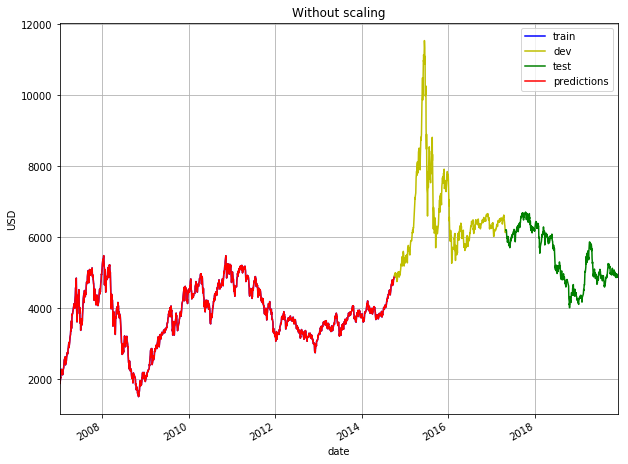

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [26]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_cv_scaled.values)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 161.518
MAPE on dev set = 1.494%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

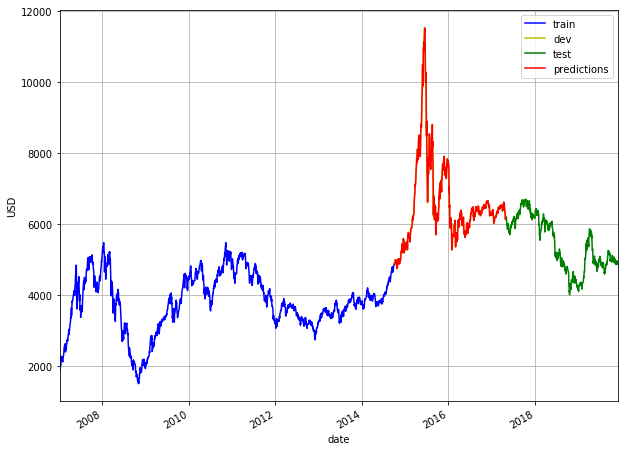

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

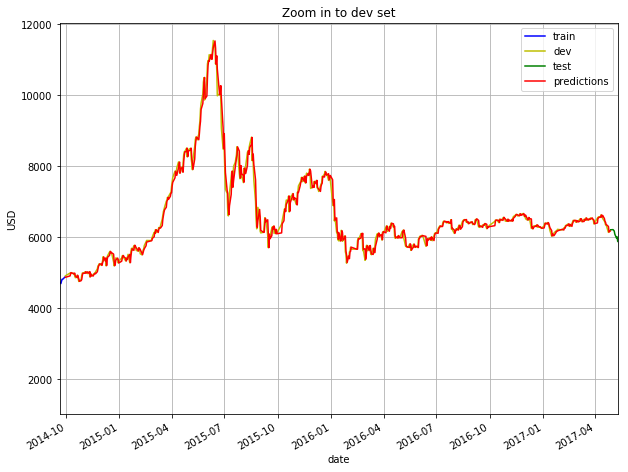

In [28]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2014, 9, 20), date(2017, 5, 10)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

Importance features dominated by adj_close and volume

# Final model

In [34]:
# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_scaled.values, y_train_scaled.values)

2019-11-29 16:38:21,286 - ../../../src/stacking/models/m1_xgb.py[line:97] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.01014	train-logloss:0.204921
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[1]	train-rmse:0.912813	train-logloss:-5.37107
[2]	train-rmse:0.825306	train-logloss:-7.14703
[3]	train-rmse:0.74588	train-logloss:-9.05436
[4]	train-rmse:0.674852	train-logloss:-11.06
[5]	train-rmse:0.610594	train-logloss:-12.1038
[6]	train-rmse:0.552994	train-logloss:-14.0991
[7]	train-rmse:0.501163	train-logloss:-14.8944
[8]	train-rmse:0.454525	train-logloss:-15.4543
[9]	train-rmse:0.41262	train-logloss:-15.7567
[10]	train-rmse:0.374831	train-logloss:-15.8613
[11]	train-rmse:0.340991	train-logloss:-16.135
[12]	train-rmse:0.310796	train-logloss:-16.2275
[13]	train-rmse:0.283712	train-logloss:-16.3421
[14]	train-rmse:0.259559	train-logloss:-16.3487
[15]	train-rmse:0.237996	train-logloss:-16.3528
[16]	train-rmse:0.218751	train-logloss:-16.3626
[17]	train-rmse:0.20178	train-logloss:-16.4045


[168]	train-rmse:0.071262	train-logloss:-16.6242
[169]	train-rmse:0.071139	train-logloss:-16.6241
[170]	train-rmse:0.071024	train-logloss:-16.6242
[171]	train-rmse:0.070984	train-logloss:-16.6242
[172]	train-rmse:0.070889	train-logloss:-16.6242
[173]	train-rmse:0.070806	train-logloss:-16.6242
[174]	train-rmse:0.070666	train-logloss:-16.6242
[175]	train-rmse:0.070578	train-logloss:-16.6242
[176]	train-rmse:0.070405	train-logloss:-16.6243
[177]	train-rmse:0.070313	train-logloss:-16.6243
[178]	train-rmse:0.070139	train-logloss:-16.6243
[179]	train-rmse:0.070053	train-logloss:-16.6243
[180]	train-rmse:0.069918	train-logloss:-16.6244
[181]	train-rmse:0.069851	train-logloss:-16.6244
[182]	train-rmse:0.069813	train-logloss:-16.6245
[183]	train-rmse:0.069772	train-logloss:-16.6245
[184]	train-rmse:0.069605	train-logloss:-16.6245
[185]	train-rmse:0.069505	train-logloss:-16.6245
[186]	train-rmse:0.069367	train-logloss:-16.6246
[187]	train-rmse:0.069271	train-logloss:-16.6246
[188]	train-rmse:0.0

[337]	train-rmse:0.058238	train-logloss:-16.6348
[338]	train-rmse:0.058199	train-logloss:-16.6348
[339]	train-rmse:0.05811	train-logloss:-16.6349
[340]	train-rmse:0.05802	train-logloss:-16.6349
[341]	train-rmse:0.05801	train-logloss:-16.6349
[342]	train-rmse:0.057955	train-logloss:-16.6349
[343]	train-rmse:0.057871	train-logloss:-16.6349
[344]	train-rmse:0.057782	train-logloss:-16.6349
[345]	train-rmse:0.057688	train-logloss:-16.635
[346]	train-rmse:0.05765	train-logloss:-16.635
[347]	train-rmse:0.057593	train-logloss:-16.6359
[348]	train-rmse:0.057568	train-logloss:-16.6359
[349]	train-rmse:0.057506	train-logloss:-16.6355
[350]	train-rmse:0.057424	train-logloss:-16.6355
[351]	train-rmse:0.057415	train-logloss:-16.6355
[352]	train-rmse:0.057373	train-logloss:-16.6355
[353]	train-rmse:0.057291	train-logloss:-16.6355
[354]	train-rmse:0.057274	train-logloss:-16.6355
[355]	train-rmse:0.057184	train-logloss:-16.6355
[356]	train-rmse:0.057155	train-logloss:-16.6355
[357]	train-rmse:0.057075	

[505]	train-rmse:0.048902	train-logloss:-16.6491
[506]	train-rmse:0.048885	train-logloss:-16.6491
[507]	train-rmse:0.048837	train-logloss:-16.6491
[508]	train-rmse:0.048756	train-logloss:-16.6497
[509]	train-rmse:0.048712	train-logloss:-16.6497
[510]	train-rmse:0.048672	train-logloss:-16.6497
[511]	train-rmse:0.048645	train-logloss:-16.6497
[512]	train-rmse:0.048609	train-logloss:-16.6497
[513]	train-rmse:0.048581	train-logloss:-16.6497
[514]	train-rmse:0.04854	train-logloss:-16.6514
[515]	train-rmse:0.048463	train-logloss:-16.6514
[516]	train-rmse:0.048387	train-logloss:-16.6515
[517]	train-rmse:0.048328	train-logloss:-16.6515
[518]	train-rmse:0.0483	train-logloss:-16.6515
[519]	train-rmse:0.048278	train-logloss:-16.6515
[520]	train-rmse:0.04822	train-logloss:-16.6515
[521]	train-rmse:0.048149	train-logloss:-16.6515
[522]	train-rmse:0.048095	train-logloss:-16.6515
[523]	train-rmse:0.048065	train-logloss:-16.6515
[524]	train-rmse:0.047987	train-logloss:-16.6516
[525]	train-rmse:0.04792

[673]	train-rmse:0.041416	train-logloss:-16.6626
[674]	train-rmse:0.041366	train-logloss:-16.6626
[675]	train-rmse:0.041298	train-logloss:-16.6626
[676]	train-rmse:0.041248	train-logloss:-16.6628
[677]	train-rmse:0.041228	train-logloss:-16.6628
[678]	train-rmse:0.041187	train-logloss:-16.663
[679]	train-rmse:0.041142	train-logloss:-16.6629
[680]	train-rmse:0.041078	train-logloss:-16.6629
[681]	train-rmse:0.041046	train-logloss:-16.6629
[682]	train-rmse:0.041026	train-logloss:-16.6629
[683]	train-rmse:0.041011	train-logloss:-16.6627
[684]	train-rmse:0.040968	train-logloss:-16.6629
[685]	train-rmse:0.040889	train-logloss:-16.6629
[686]	train-rmse:0.040838	train-logloss:-16.6629
[687]	train-rmse:0.040812	train-logloss:-16.6629
[688]	train-rmse:0.040801	train-logloss:-16.6629
[689]	train-rmse:0.040769	train-logloss:-16.6629
[690]	train-rmse:0.040759	train-logloss:-16.6629
[691]	train-rmse:0.040706	train-logloss:-16.6629
[692]	train-rmse:0.040678	train-logloss:-16.663
[693]	train-rmse:0.040

[842]	train-rmse:0.03539	train-logloss:-16.6665
[843]	train-rmse:0.035382	train-logloss:-16.6665
[844]	train-rmse:0.035349	train-logloss:-16.6665
[845]	train-rmse:0.035328	train-logloss:-16.6665
[846]	train-rmse:0.035288	train-logloss:-16.6665
[847]	train-rmse:0.035229	train-logloss:-16.6667
[848]	train-rmse:0.035189	train-logloss:-16.6667
[849]	train-rmse:0.035123	train-logloss:-16.6668
[850]	train-rmse:0.035087	train-logloss:-16.6668
[851]	train-rmse:0.035051	train-logloss:-16.6668
[852]	train-rmse:0.035018	train-logloss:-16.6668
[853]	train-rmse:0.034977	train-logloss:-16.6668
[854]	train-rmse:0.034947	train-logloss:-16.6666
[855]	train-rmse:0.03491	train-logloss:-16.6669
[856]	train-rmse:0.034873	train-logloss:-16.6669
[857]	train-rmse:0.034824	train-logloss:-16.6669
[858]	train-rmse:0.034789	train-logloss:-16.6669
[859]	train-rmse:0.034738	train-logloss:-16.6669
[860]	train-rmse:0.034709	train-logloss:-16.6669
[861]	train-rmse:0.034658	train-logloss:-16.667
[862]	train-rmse:0.0346

[1010]	train-rmse:0.030398	train-logloss:-16.6743
[1011]	train-rmse:0.030374	train-logloss:-16.6743
[1012]	train-rmse:0.030345	train-logloss:-16.6743
[1013]	train-rmse:0.030312	train-logloss:-16.6743
[1014]	train-rmse:0.03028	train-logloss:-16.6744
[1015]	train-rmse:0.030243	train-logloss:-16.6744
[1016]	train-rmse:0.030204	train-logloss:-16.6744
[1017]	train-rmse:0.03018	train-logloss:-16.6744
[1018]	train-rmse:0.030147	train-logloss:-16.6744
[1019]	train-rmse:0.030114	train-logloss:-16.6744
[1020]	train-rmse:0.030076	train-logloss:-16.6744
[1021]	train-rmse:0.030053	train-logloss:-16.6744
[1022]	train-rmse:0.030027	train-logloss:-16.6744
[1023]	train-rmse:0.030007	train-logloss:-16.6744
[1024]	train-rmse:0.029969	train-logloss:-16.6744
[1025]	train-rmse:0.029961	train-logloss:-16.6744
[1026]	train-rmse:0.029952	train-logloss:-16.6744
[1027]	train-rmse:0.02991	train-logloss:-16.6745
[1028]	train-rmse:0.029872	train-logloss:-16.6745
[1029]	train-rmse:0.029869	train-logloss:-16.6745
[10

[1175]	train-rmse:0.025966	train-logloss:-16.6786
[1176]	train-rmse:0.025938	train-logloss:-16.6786
[1177]	train-rmse:0.025912	train-logloss:-16.6786
[1178]	train-rmse:0.025875	train-logloss:-16.6786
[1179]	train-rmse:0.025843	train-logloss:-16.6786
[1180]	train-rmse:0.025822	train-logloss:-16.6786
[1181]	train-rmse:0.025803	train-logloss:-16.6789
[1182]	train-rmse:0.025785	train-logloss:-16.6789
[1183]	train-rmse:0.025743	train-logloss:-16.6786
[1184]	train-rmse:0.025727	train-logloss:-16.6786
[1185]	train-rmse:0.025722	train-logloss:-16.6786
[1186]	train-rmse:0.025695	train-logloss:-16.6786
[1187]	train-rmse:0.025657	train-logloss:-16.6786
[1188]	train-rmse:0.025641	train-logloss:-16.6786
[1189]	train-rmse:0.025612	train-logloss:-16.6786
[1190]	train-rmse:0.02559	train-logloss:-16.6786
[1191]	train-rmse:0.025578	train-logloss:-16.6786
[1192]	train-rmse:0.02555	train-logloss:-16.6786
[1193]	train-rmse:0.025527	train-logloss:-16.6786
[1194]	train-rmse:0.025496	train-logloss:-16.6786
[1

[1340]	train-rmse:0.022407	train-logloss:-16.6811
[1341]	train-rmse:0.022383	train-logloss:-16.6811
[1342]	train-rmse:0.02237	train-logloss:-16.6811
[1343]	train-rmse:0.022343	train-logloss:-16.6811
[1344]	train-rmse:0.022329	train-logloss:-16.6811
[1345]	train-rmse:0.022318	train-logloss:-16.6811
[1346]	train-rmse:0.022299	train-logloss:-16.6811
[1347]	train-rmse:0.022276	train-logloss:-16.6811
[1348]	train-rmse:0.022249	train-logloss:-16.6811
[1349]	train-rmse:0.022232	train-logloss:-16.6811
[1350]	train-rmse:0.022204	train-logloss:-16.6813
[1351]	train-rmse:0.022183	train-logloss:-16.6813
[1352]	train-rmse:0.022163	train-logloss:-16.6813
[1353]	train-rmse:0.022132	train-logloss:-16.6813
[1354]	train-rmse:0.022108	train-logloss:-16.6814
[1355]	train-rmse:0.022084	train-logloss:-16.6813
[1356]	train-rmse:0.022061	train-logloss:-16.6814
[1357]	train-rmse:0.022053	train-logloss:-16.6814
[1358]	train-rmse:0.022042	train-logloss:-16.6815
[1359]	train-rmse:0.022021	train-logloss:-16.6815
[

[1505]	train-rmse:0.019352	train-logloss:-16.6845
[1506]	train-rmse:0.019322	train-logloss:-16.6845
[1507]	train-rmse:0.019311	train-logloss:-16.6845
[1508]	train-rmse:0.019303	train-logloss:-16.6845
[1509]	train-rmse:0.019299	train-logloss:-16.6845
[1510]	train-rmse:0.019278	train-logloss:-16.6845
[1511]	train-rmse:0.019258	train-logloss:-16.6845
[1512]	train-rmse:0.019251	train-logloss:-16.6845
[1513]	train-rmse:0.019239	train-logloss:-16.6852
[1514]	train-rmse:0.01922	train-logloss:-16.6852
[1515]	train-rmse:0.019198	train-logloss:-16.6852
[1516]	train-rmse:0.019172	train-logloss:-16.6852
[1517]	train-rmse:0.019157	train-logloss:-16.6852
[1518]	train-rmse:0.019139	train-logloss:-16.6852
[1519]	train-rmse:0.019123	train-logloss:-16.6852
[1520]	train-rmse:0.019121	train-logloss:-16.6852
[1521]	train-rmse:0.019113	train-logloss:-16.6852
[1522]	train-rmse:0.019106	train-logloss:-16.6852
[1523]	train-rmse:0.019084	train-logloss:-16.6852
[1524]	train-rmse:0.01906	train-logloss:-16.6852
[1

[1670]	train-rmse:0.016848	train-logloss:-16.6867
[1671]	train-rmse:0.016838	train-logloss:-16.6867
[1672]	train-rmse:0.016831	train-logloss:-16.6867
[1673]	train-rmse:0.016817	train-logloss:-16.6867
[1674]	train-rmse:0.016812	train-logloss:-16.6867
[1675]	train-rmse:0.016792	train-logloss:-16.6867
[1676]	train-rmse:0.01677	train-logloss:-16.6867
[1677]	train-rmse:0.016749	train-logloss:-16.6867
[1678]	train-rmse:0.016724	train-logloss:-16.6867
[1679]	train-rmse:0.016707	train-logloss:-16.6867
[1680]	train-rmse:0.016689	train-logloss:-16.6867
[1681]	train-rmse:0.016682	train-logloss:-16.6867
[1682]	train-rmse:0.016673	train-logloss:-16.6867
[1683]	train-rmse:0.016656	train-logloss:-16.6875
[1684]	train-rmse:0.016647	train-logloss:-16.6875
[1685]	train-rmse:0.016629	train-logloss:-16.6875
[1686]	train-rmse:0.016617	train-logloss:-16.6875
[1687]	train-rmse:0.016599	train-logloss:-16.6875
[1688]	train-rmse:0.016584	train-logloss:-16.6875
[1689]	train-rmse:0.016567	train-logloss:-16.6875
[

[1835]	train-rmse:0.014794	train-logloss:-16.6878
[1836]	train-rmse:0.014779	train-logloss:-16.6878
[1837]	train-rmse:0.014765	train-logloss:-16.6878
[1838]	train-rmse:0.014753	train-logloss:-16.6878
[1839]	train-rmse:0.014748	train-logloss:-16.6878
[1840]	train-rmse:0.014732	train-logloss:-16.6878
[1841]	train-rmse:0.01473	train-logloss:-16.6878
[1842]	train-rmse:0.014722	train-logloss:-16.6878
[1843]	train-rmse:0.014709	train-logloss:-16.6878
[1844]	train-rmse:0.014688	train-logloss:-16.6878
[1845]	train-rmse:0.014668	train-logloss:-16.6878
[1846]	train-rmse:0.014662	train-logloss:-16.6878
[1847]	train-rmse:0.014644	train-logloss:-16.6878
[1848]	train-rmse:0.014641	train-logloss:-16.6878
[1849]	train-rmse:0.014628	train-logloss:-16.6878
[1850]	train-rmse:0.014616	train-logloss:-16.6878
[1851]	train-rmse:0.014612	train-logloss:-16.6878
[1852]	train-rmse:0.014593	train-logloss:-16.6878
[1853]	train-rmse:0.014578	train-logloss:-16.6878
[1854]	train-rmse:0.014566	train-logloss:-16.6878
[

[2000]	train-rmse:0.013056	train-logloss:-16.6881
[2001]	train-rmse:0.013047	train-logloss:-16.6881
[2002]	train-rmse:0.013034	train-logloss:-16.6881
[2003]	train-rmse:0.013025	train-logloss:-16.6881
[2004]	train-rmse:0.013015	train-logloss:-16.6881
[2005]	train-rmse:0.013008	train-logloss:-16.6881
[2006]	train-rmse:0.012997	train-logloss:-16.6881
[2007]	train-rmse:0.012988	train-logloss:-16.6881
[2008]	train-rmse:0.012983	train-logloss:-16.6881
[2009]	train-rmse:0.012979	train-logloss:-16.6881
[2010]	train-rmse:0.012973	train-logloss:-16.6881
[2011]	train-rmse:0.012967	train-logloss:-16.6881
[2012]	train-rmse:0.012964	train-logloss:-16.6881
[2013]	train-rmse:0.012943	train-logloss:-16.6881
[2014]	train-rmse:0.012936	train-logloss:-16.6881
[2015]	train-rmse:0.012928	train-logloss:-16.6881
[2016]	train-rmse:0.012913	train-logloss:-16.6881
[2017]	train-rmse:0.012906	train-logloss:-16.6881
[2018]	train-rmse:0.012901	train-logloss:-16.6881
[2019]	train-rmse:0.012887	train-logloss:-16.6881


[2165]	train-rmse:0.011551	train-logloss:-16.6889
[2166]	train-rmse:0.011539	train-logloss:-16.6889
[2167]	train-rmse:0.01153	train-logloss:-16.6889
[2168]	train-rmse:0.011518	train-logloss:-16.6889
[2169]	train-rmse:0.011508	train-logloss:-16.6889
[2170]	train-rmse:0.011499	train-logloss:-16.6889
[2171]	train-rmse:0.01149	train-logloss:-16.6889
[2172]	train-rmse:0.011476	train-logloss:-16.6889
[2173]	train-rmse:0.011469	train-logloss:-16.6889
[2174]	train-rmse:0.011464	train-logloss:-16.6889
[2175]	train-rmse:0.011461	train-logloss:-16.6889
[2176]	train-rmse:0.01146	train-logloss:-16.6889
[2177]	train-rmse:0.01145	train-logloss:-16.6889
[2178]	train-rmse:0.011439	train-logloss:-16.6889
[2179]	train-rmse:0.011436	train-logloss:-16.6889
[2180]	train-rmse:0.011433	train-logloss:-16.6889
[2181]	train-rmse:0.011426	train-logloss:-16.6889
[2182]	train-rmse:0.011425	train-logloss:-16.6889
[2183]	train-rmse:0.011417	train-logloss:-16.6889
[2184]	train-rmse:0.011403	train-logloss:-16.6889
[218

[2331]	train-rmse:0.010133	train-logloss:-16.6891
[2332]	train-rmse:0.010125	train-logloss:-16.6891
[2333]	train-rmse:0.010116	train-logloss:-16.6891
[2334]	train-rmse:0.010111	train-logloss:-16.6891
[2335]	train-rmse:0.010101	train-logloss:-16.6891
[2336]	train-rmse:0.010095	train-logloss:-16.6891
[2337]	train-rmse:0.010087	train-logloss:-16.6891
[2338]	train-rmse:0.010078	train-logloss:-16.6891
[2339]	train-rmse:0.010067	train-logloss:-16.6891
[2340]	train-rmse:0.010063	train-logloss:-16.6891
[2341]	train-rmse:0.010056	train-logloss:-16.6891
[2342]	train-rmse:0.01005	train-logloss:-16.6891
[2343]	train-rmse:0.010046	train-logloss:-16.6891
[2344]	train-rmse:0.010037	train-logloss:-16.6891
[2345]	train-rmse:0.010028	train-logloss:-16.6891
[2346]	train-rmse:0.010021	train-logloss:-16.6891
[2347]	train-rmse:0.010011	train-logloss:-16.6894
[2348]	train-rmse:0.010004	train-logloss:-16.6894
[2349]	train-rmse:0.009999	train-logloss:-16.6894
[2350]	train-rmse:0.009994	train-logloss:-16.6894
[

[2496]	train-rmse:0.008979	train-logloss:-16.6899
[2497]	train-rmse:0.008969	train-logloss:-16.6899
[2498]	train-rmse:0.008965	train-logloss:-16.6899
[2499]	train-rmse:0.008963	train-logloss:-16.6899
[2500]	train-rmse:0.008958	train-logloss:-16.6899
[2501]	train-rmse:0.008952	train-logloss:-16.6899
[2502]	train-rmse:0.008942	train-logloss:-16.6899
[2503]	train-rmse:0.008938	train-logloss:-16.6899
[2504]	train-rmse:0.008931	train-logloss:-16.6899
[2505]	train-rmse:0.008923	train-logloss:-16.6899
[2506]	train-rmse:0.00892	train-logloss:-16.6899
[2507]	train-rmse:0.008911	train-logloss:-16.6899
[2508]	train-rmse:0.008909	train-logloss:-16.6899
[2509]	train-rmse:0.0089	train-logloss:-16.6899
[2510]	train-rmse:0.008892	train-logloss:-16.6899
[2511]	train-rmse:0.008885	train-logloss:-16.6899
[2512]	train-rmse:0.008873	train-logloss:-16.6899
[2513]	train-rmse:0.008855	train-logloss:-16.6899
[2514]	train-rmse:0.008849	train-logloss:-16.6899
[2515]	train-rmse:0.008841	train-logloss:-16.6899
[25

[2661]	train-rmse:0.007914	train-logloss:-16.69
[2662]	train-rmse:0.007912	train-logloss:-16.69
[2663]	train-rmse:0.007907	train-logloss:-16.69
[2664]	train-rmse:0.007898	train-logloss:-16.69
[2665]	train-rmse:0.007893	train-logloss:-16.69
[2666]	train-rmse:0.007886	train-logloss:-16.69
[2667]	train-rmse:0.007879	train-logloss:-16.69
[2668]	train-rmse:0.007877	train-logloss:-16.69
[2669]	train-rmse:0.00787	train-logloss:-16.69
[2670]	train-rmse:0.007861	train-logloss:-16.69
[2671]	train-rmse:0.007852	train-logloss:-16.69
[2672]	train-rmse:0.007846	train-logloss:-16.69
[2673]	train-rmse:0.007839	train-logloss:-16.69
[2674]	train-rmse:0.007832	train-logloss:-16.69
[2675]	train-rmse:0.007829	train-logloss:-16.69
[2676]	train-rmse:0.007825	train-logloss:-16.69
[2677]	train-rmse:0.007822	train-logloss:-16.69
[2678]	train-rmse:0.007814	train-logloss:-16.69
[2679]	train-rmse:0.00781	train-logloss:-16.69
[2680]	train-rmse:0.00781	train-logloss:-16.69
[2681]	train-rmse:0.007805	train-logloss:-1

[2830]	train-rmse:0.006999	train-logloss:-16.6902
[2831]	train-rmse:0.006995	train-logloss:-16.6902
[2832]	train-rmse:0.006988	train-logloss:-16.6902
[2833]	train-rmse:0.006984	train-logloss:-16.6902
[2834]	train-rmse:0.006979	train-logloss:-16.6902
[2835]	train-rmse:0.006977	train-logloss:-16.6902
[2836]	train-rmse:0.006974	train-logloss:-16.6902
[2837]	train-rmse:0.006966	train-logloss:-16.6902
[2838]	train-rmse:0.006958	train-logloss:-16.6902
[2839]	train-rmse:0.006951	train-logloss:-16.6902
[2840]	train-rmse:0.006948	train-logloss:-16.6902
[2841]	train-rmse:0.006943	train-logloss:-16.6902
[2842]	train-rmse:0.006936	train-logloss:-16.6902
[2843]	train-rmse:0.006928	train-logloss:-16.6902
[2844]	train-rmse:0.00692	train-logloss:-16.6902
[2845]	train-rmse:0.006912	train-logloss:-16.6902
[2846]	train-rmse:0.006906	train-logloss:-16.6902
[2847]	train-rmse:0.006897	train-logloss:-16.6902
[2848]	train-rmse:0.006891	train-logloss:-16.6902
[2849]	train-rmse:0.006885	train-logloss:-16.6902
[

[2995]	train-rmse:0.006167	train-logloss:-16.6907
[2996]	train-rmse:0.006166	train-logloss:-16.6907
[2997]	train-rmse:0.006161	train-logloss:-16.6907
[2998]	train-rmse:0.006155	train-logloss:-16.6907
[2999]	train-rmse:0.006149	train-logloss:-16.6907
[3000]	train-rmse:0.006144	train-logloss:-16.6907
[3001]	train-rmse:0.006137	train-logloss:-16.6907
[3002]	train-rmse:0.006132	train-logloss:-16.6907
[3003]	train-rmse:0.006127	train-logloss:-16.6907
[3004]	train-rmse:0.00612	train-logloss:-16.6907
[3005]	train-rmse:0.006115	train-logloss:-16.6907
[3006]	train-rmse:0.006112	train-logloss:-16.6907
[3007]	train-rmse:0.006104	train-logloss:-16.6907
[3008]	train-rmse:0.006098	train-logloss:-16.6907
[3009]	train-rmse:0.006092	train-logloss:-16.6907
[3010]	train-rmse:0.006087	train-logloss:-16.6907
[3011]	train-rmse:0.00608	train-logloss:-16.6907
[3012]	train-rmse:0.006075	train-logloss:-16.6907
[3013]	train-rmse:0.006074	train-logloss:-16.6907
[3014]	train-rmse:0.006073	train-logloss:-16.6907
[3

[3160]	train-rmse:0.005457	train-logloss:-16.6908
[3161]	train-rmse:0.005449	train-logloss:-16.6908
[3162]	train-rmse:0.005445	train-logloss:-16.6908
[3163]	train-rmse:0.005439	train-logloss:-16.6908
[3164]	train-rmse:0.005431	train-logloss:-16.6908
[3165]	train-rmse:0.005428	train-logloss:-16.6908
[3166]	train-rmse:0.005424	train-logloss:-16.6908
[3167]	train-rmse:0.005416	train-logloss:-16.6908
[3168]	train-rmse:0.005413	train-logloss:-16.6908
[3169]	train-rmse:0.005411	train-logloss:-16.6908
[3170]	train-rmse:0.005407	train-logloss:-16.6908
[3171]	train-rmse:0.005403	train-logloss:-16.6908
[3172]	train-rmse:0.005401	train-logloss:-16.6908
[3173]	train-rmse:0.005397	train-logloss:-16.6908
[3174]	train-rmse:0.005391	train-logloss:-16.6908
[3175]	train-rmse:0.005388	train-logloss:-16.6908
[3176]	train-rmse:0.005383	train-logloss:-16.6908
[3177]	train-rmse:0.005376	train-logloss:-16.6908
[3178]	train-rmse:0.005372	train-logloss:-16.6908
[3179]	train-rmse:0.005368	train-logloss:-16.6908


[3325]	train-rmse:0.004818	train-logloss:-16.6908
[3326]	train-rmse:0.004816	train-logloss:-16.6908
[3327]	train-rmse:0.004809	train-logloss:-16.6908
[3328]	train-rmse:0.004806	train-logloss:-16.6908
[3329]	train-rmse:0.004805	train-logloss:-16.6908
[3330]	train-rmse:0.004804	train-logloss:-16.6908
[3331]	train-rmse:0.0048	train-logloss:-16.6908
[3332]	train-rmse:0.004798	train-logloss:-16.6908
[3333]	train-rmse:0.004798	train-logloss:-16.6908
[3334]	train-rmse:0.004793	train-logloss:-16.6908
[3335]	train-rmse:0.004788	train-logloss:-16.6908
[3336]	train-rmse:0.004787	train-logloss:-16.6908
[3337]	train-rmse:0.004784	train-logloss:-16.6908
[3338]	train-rmse:0.004779	train-logloss:-16.6909
[3339]	train-rmse:0.004779	train-logloss:-16.6909
[3340]	train-rmse:0.004777	train-logloss:-16.6909
[3341]	train-rmse:0.004773	train-logloss:-16.6909
[3342]	train-rmse:0.00477	train-logloss:-16.6909
[3343]	train-rmse:0.004769	train-logloss:-16.6909
[3344]	train-rmse:0.004767	train-logloss:-16.6909
[33

[3490]	train-rmse:0.004282	train-logloss:-16.6913
[3491]	train-rmse:0.00428	train-logloss:-16.6913
[3492]	train-rmse:0.004271	train-logloss:-16.6913
[3493]	train-rmse:0.004268	train-logloss:-16.6913
[3494]	train-rmse:0.004265	train-logloss:-16.6913
[3495]	train-rmse:0.004261	train-logloss:-16.6913
[3496]	train-rmse:0.004261	train-logloss:-16.6913
[3497]	train-rmse:0.004257	train-logloss:-16.6913
[3498]	train-rmse:0.004252	train-logloss:-16.6913
[3499]	train-rmse:0.004249	train-logloss:-16.6913
[3500]	train-rmse:0.004245	train-logloss:-16.6913
[3501]	train-rmse:0.004242	train-logloss:-16.6913
[3502]	train-rmse:0.004237	train-logloss:-16.6913
[3503]	train-rmse:0.004234	train-logloss:-16.6913
[3504]	train-rmse:0.00423	train-logloss:-16.6913
[3505]	train-rmse:0.004228	train-logloss:-16.6913
[3506]	train-rmse:0.004226	train-logloss:-16.6913
[3507]	train-rmse:0.004225	train-logloss:-16.6913
[3508]	train-rmse:0.004225	train-logloss:-16.6913
[3509]	train-rmse:0.004222	train-logloss:-16.6913
[3

[3655]	train-rmse:0.003792	train-logloss:-16.6914
[3656]	train-rmse:0.00379	train-logloss:-16.6914
[3657]	train-rmse:0.003788	train-logloss:-16.6914
[3658]	train-rmse:0.003785	train-logloss:-16.6914
[3659]	train-rmse:0.00378	train-logloss:-16.6914
[3660]	train-rmse:0.003776	train-logloss:-16.6914
[3661]	train-rmse:0.003772	train-logloss:-16.6914
[3662]	train-rmse:0.003768	train-logloss:-16.6914
[3663]	train-rmse:0.003764	train-logloss:-16.6914
[3664]	train-rmse:0.003759	train-logloss:-16.6914
[3665]	train-rmse:0.003756	train-logloss:-16.6914
[3666]	train-rmse:0.003753	train-logloss:-16.6914
[3667]	train-rmse:0.003753	train-logloss:-16.6914
[3668]	train-rmse:0.00375	train-logloss:-16.6914
[3669]	train-rmse:0.003746	train-logloss:-16.6914
[3670]	train-rmse:0.003745	train-logloss:-16.6914
[3671]	train-rmse:0.003743	train-logloss:-16.6914
[3672]	train-rmse:0.003741	train-logloss:-16.6914
[3673]	train-rmse:0.003739	train-logloss:-16.6914
[3674]	train-rmse:0.003739	train-logloss:-16.6914
[36

[3820]	train-rmse:0.003379	train-logloss:-16.6914
[3821]	train-rmse:0.003377	train-logloss:-16.6914
[3822]	train-rmse:0.003374	train-logloss:-16.6914
[3823]	train-rmse:0.003371	train-logloss:-16.6914
[3824]	train-rmse:0.003369	train-logloss:-16.6914
[3825]	train-rmse:0.003366	train-logloss:-16.6914
[3826]	train-rmse:0.003363	train-logloss:-16.6914
[3827]	train-rmse:0.003359	train-logloss:-16.6914
[3828]	train-rmse:0.003356	train-logloss:-16.6914
[3829]	train-rmse:0.003354	train-logloss:-16.6914
[3830]	train-rmse:0.003351	train-logloss:-16.6914
[3831]	train-rmse:0.003347	train-logloss:-16.6914
[3832]	train-rmse:0.003346	train-logloss:-16.6914
[3833]	train-rmse:0.003344	train-logloss:-16.6914
[3834]	train-rmse:0.003344	train-logloss:-16.6914
[3835]	train-rmse:0.003341	train-logloss:-16.6914
[3836]	train-rmse:0.003338	train-logloss:-16.6914
[3837]	train-rmse:0.003335	train-logloss:-16.6914
[3838]	train-rmse:0.003332	train-logloss:-16.6914
[3839]	train-rmse:0.003331	train-logloss:-16.6914


[3985]	train-rmse:0.002993	train-logloss:-16.6915
[3986]	train-rmse:0.002989	train-logloss:-16.6915
[3987]	train-rmse:0.002986	train-logloss:-16.6915
[3988]	train-rmse:0.002982	train-logloss:-16.6915
[3989]	train-rmse:0.002981	train-logloss:-16.6915
[3990]	train-rmse:0.002979	train-logloss:-16.6915
[3991]	train-rmse:0.002977	train-logloss:-16.6915
[3992]	train-rmse:0.002974	train-logloss:-16.6915
[3993]	train-rmse:0.002972	train-logloss:-16.6915
[3994]	train-rmse:0.002969	train-logloss:-16.6915
[3995]	train-rmse:0.002966	train-logloss:-16.6915
[3996]	train-rmse:0.002964	train-logloss:-16.6915
[3997]	train-rmse:0.002963	train-logloss:-16.6915
[3998]	train-rmse:0.00296	train-logloss:-16.6915
[3999]	train-rmse:0.002959	train-logloss:-16.6915
[4000]	train-rmse:0.002958	train-logloss:-16.6915
[4001]	train-rmse:0.002957	train-logloss:-16.6915
[4002]	train-rmse:0.002955	train-logloss:-16.6915
[4003]	train-rmse:0.002952	train-logloss:-16.6915
[4004]	train-rmse:0.002951	train-logloss:-16.6915
[

[4150]	train-rmse:0.002687	train-logloss:-16.6915
[4151]	train-rmse:0.002687	train-logloss:-16.6915
[4152]	train-rmse:0.002686	train-logloss:-16.6915
[4153]	train-rmse:0.002684	train-logloss:-16.6915
[4154]	train-rmse:0.002684	train-logloss:-16.6915
[4155]	train-rmse:0.002683	train-logloss:-16.6915
[4156]	train-rmse:0.002681	train-logloss:-16.6915
[4157]	train-rmse:0.00268	train-logloss:-16.6915
[4158]	train-rmse:0.002678	train-logloss:-16.6915
[4159]	train-rmse:0.002676	train-logloss:-16.6915
[4160]	train-rmse:0.002674	train-logloss:-16.6915
[4161]	train-rmse:0.002672	train-logloss:-16.6915
[4162]	train-rmse:0.002669	train-logloss:-16.6915
[4163]	train-rmse:0.002668	train-logloss:-16.6915
[4164]	train-rmse:0.002665	train-logloss:-16.6915
[4165]	train-rmse:0.002663	train-logloss:-16.6915
[4166]	train-rmse:0.002663	train-logloss:-16.6915
[4167]	train-rmse:0.002663	train-logloss:-16.6915
[4168]	train-rmse:0.002661	train-logloss:-16.6915
[4169]	train-rmse:0.002659	train-logloss:-16.6915
[

[4315]	train-rmse:0.002413	train-logloss:-16.6915
[4316]	train-rmse:0.002412	train-logloss:-16.6915
[4317]	train-rmse:0.002411	train-logloss:-16.6915
[4318]	train-rmse:0.002409	train-logloss:-16.6915
[4319]	train-rmse:0.002405	train-logloss:-16.6915
[4320]	train-rmse:0.002404	train-logloss:-16.6915
[4321]	train-rmse:0.002403	train-logloss:-16.6915
[4322]	train-rmse:0.0024	train-logloss:-16.6915
[4323]	train-rmse:0.002399	train-logloss:-16.6915
[4324]	train-rmse:0.002397	train-logloss:-16.6915
[4325]	train-rmse:0.002393	train-logloss:-16.6915
[4326]	train-rmse:0.002393	train-logloss:-16.6915
[4327]	train-rmse:0.00239	train-logloss:-16.6915
[4328]	train-rmse:0.002388	train-logloss:-16.6915
[4329]	train-rmse:0.002387	train-logloss:-16.6915
[4330]	train-rmse:0.002386	train-logloss:-16.6915
[4331]	train-rmse:0.002384	train-logloss:-16.6915
[4332]	train-rmse:0.002383	train-logloss:-16.6915
[4333]	train-rmse:0.002381	train-logloss:-16.6915
[4334]	train-rmse:0.00238	train-logloss:-16.6915
[433

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[5269]	train-rmse:0.00229	train-logloss:-16.6915
[5270]	train-rmse:0.00229	train-logloss:-16.6915
[5271]	train-rmse:0.00229	train-logloss:-16.6915
[5272]	train-rmse:0.00229	train-logloss:-16.6915
[5273]	train-rmse:0.00229	train-logloss:-16.6915
[5274]	train-rmse:0.00229	train-logloss:-16.6915
[5275]	train-rmse:0.00229	train-logloss:-16.6915
[5276]	train-rmse:0.00229	train-logloss:-16.6915
[5277]	train-rmse:0.00229	train-logloss:-16.6915
[5278]	train-rmse:0.00229	train-logloss:-16.6915
[5279]	train-rmse:0.00229	train-logloss:-16.6915
[5280]	train-rmse:0.00229	train-logloss:-16.6915
[5281]	train-rmse:0.00229	train-logloss:-16.6915
[5282]	train-rmse:0.00229	train-logloss:-16.6915
[5283]	train-rmse:0.00229	train-logloss:-16.6915
[5284]	train-rmse:0.00229	train-logloss:-16.6915
[5285]	train-rmse:0.00229	train-logloss:-16.6915
[5286]	train-rmse:0.00229	train-logloss:-16.6915
[5287]	train-rmse:0.00229	train-logloss:-16.6915
[5288]	train-rmse:0.00229	train-logloss:-16.6915
[5289]	train-rmse:0.

In [35]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_sample_scaled.values)
test['est_scaled'] = est_scaled
test['est'] = test['est_scaled'] * test['adj_close_std'] + test['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_sample, test['est']))
print("RMSE on test set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on test set = %0.3f%%" % mape_bef_tuning)

RMSE on test set = 74.433
MAPE on test set = 1.494%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

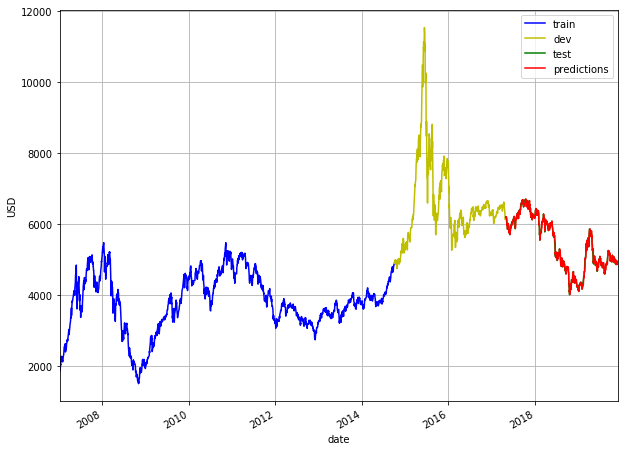

In [36]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': test['est'], 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

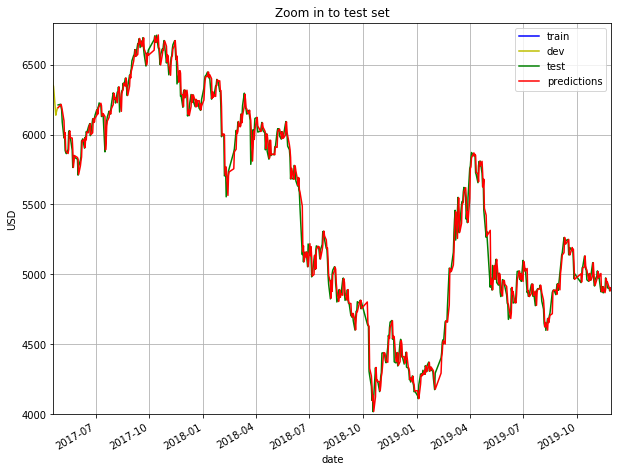

In [37]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([4000, 6800])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

(3944, 6730)

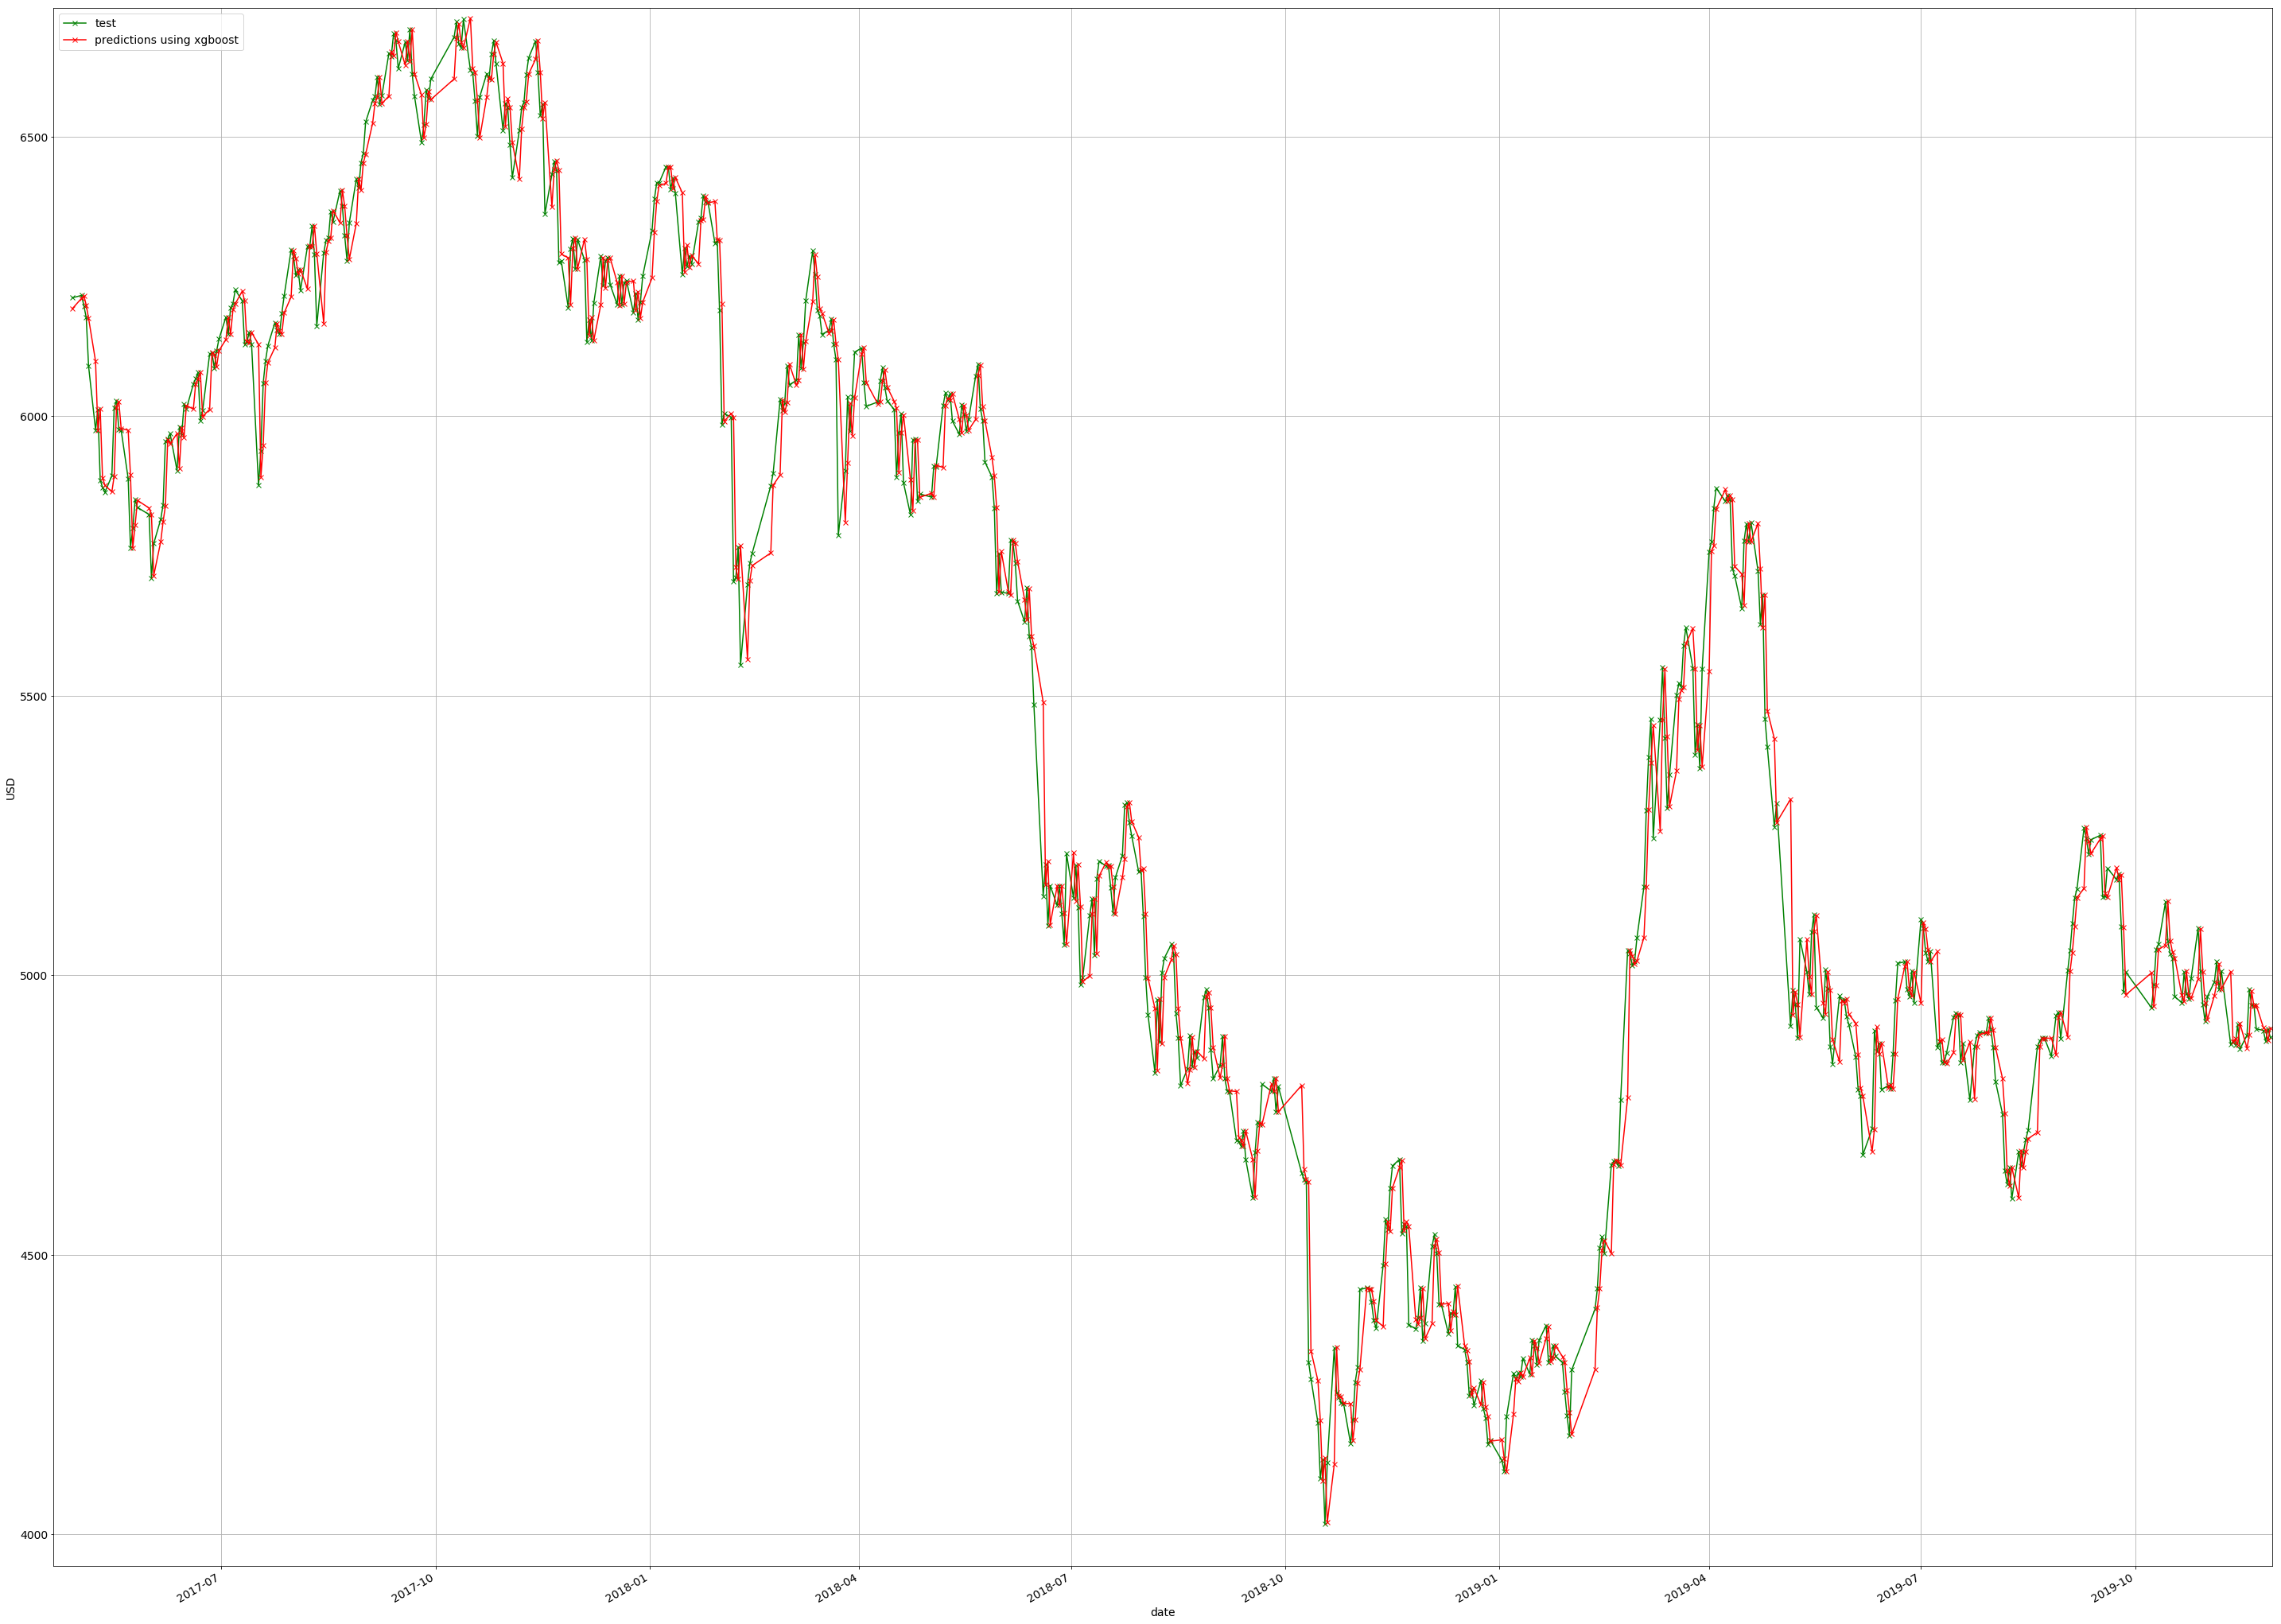

In [38]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 50, 40 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([3944, 6730])

In [39]:
# Save as csv
test_xgboost = est_df
test_xgboost.to_csv("./out/test_xgboost.csv")

FileNotFoundError: [Errno 2] No such file or directory: './out/test_xgboost.csv'

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively